# Аналитика в Яндекс.Афише

_В этом исследовании необходимо проанализировать 3 таблицы с данными сервиса Яндекс.Афиша, чтобы дать рекомендации отделу маркетинга как оптимизировать маркетинговые затраты._

Основные задачи, которые необходимо решить в исследовании:
 - [изучение данных](#first_touch);
 - [предобработка и подготовка данных для анализа](#preprocessing);
 - [расчет дополнительных метрик и анализ данных](#additional_metrics_data_analysis);
 - [вывод и рекомендации](#conclusion).

## Изучение данных <a id="first_touch"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
warnings.simplefilter("ignore")

In [3]:
visits = pd.read_csv('/datasets/visits_log.csv')

In [4]:
orders = pd.read_csv('/datasets/orders_log.csv')

In [5]:
costs = pd.read_csv('/datasets/costs.csv')

In [6]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [7]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [8]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [10]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [11]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


В результате изучения данных можно сделать следующие выводы:
 - все датафреймы имеют информацию без пропусков;
 - все столбцы с данными о датах записаны с типом данных object. Для большей вариативности действий стоит поменять тип данных этих столбцов на соответствующий дате;
 - проанализировав детально все столбцы каждого датафрейма я не нашел критических ошибок в данных. Если они обнаружатся, я буду исправлять их по мере выполнения проекта.

## Предобработка и подготовка данных для анализа <a id="preprocessing"></a>

_**Датафрейм visits**_

In [12]:
visits.columns = visits.columns.str.lower()

In [13]:
visits.columns = visits.columns.str.replace(' ','_')

In [14]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format='%Y-%m-%d %H:%M:%S')

In [15]:
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format='%Y-%m-%d %H:%M:%S')

In [16]:
visits.duplicated().sum()

0

_**Датафрейм orders**_

In [17]:
orders.columns = orders.columns.str.replace(' ','_')

In [18]:
orders.columns = orders.columns.str.lower()

In [19]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format='%Y-%m-%d %H:%M:%S')

In [20]:
orders.duplicated().sum()

0

_**Датафрейм costs**_

In [21]:
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d')

In [22]:
costs.duplicated().sum()

0

В результате предобработки я заменил типы данных на соответствующие характеру информации в столбце и привел названия столбцов к более удобной записи. Проверка на дубликаты показала их отсутствие в каждом из 3 датафреймов.

## Расчет дополнительных метрик <a id="additional_metrics_data_analysis"></a>

### _Продукт_

#### _Сколько людей пользуются в день, неделю, месяц?_

In [23]:
visits['session_year'] = visits['start_ts'].dt.year

In [24]:
visits['session_month'] = visits['start_ts'].dt.month

In [25]:
visits['session_week'] = visits['start_ts'].dt.week

In [26]:
visits['session_date'] = visits['start_ts'].dt.date

In [27]:
dau_mean = visits.groupby(['session_year','session_date']).agg({'uid':'nunique'}).mean()

In [28]:
int(dau_mean)

907

In [29]:
wau_mean = visits.groupby(['session_year','session_week']).agg({'uid':'nunique'}).mean()

In [30]:
int(wau_mean)

5716

In [31]:
mau_mean = visits.groupby(['session_year','session_month']).agg({'uid':'nunique'}).mean()

In [32]:
int(mau_mean)

23228

23228 уникальных активных пользователя у сервиса Яндекс.Афиша, это хороший абсолютный показатель. Интересно какую долю на рынке услуг  занимает Яндекс в этом сегменте.

#### _Сколько сессий в день?_

In [33]:
sessions = visits.groupby(['session_year','session_date']).agg({'uid':['count','nunique']})

In [34]:
sessions.columns = ['n_sessions','n_unique']

In [35]:
sessions['session_per_user'] = sessions['n_sessions'] / sessions['n_unique']

In [36]:
sessions

n_sessions  n_unique  session_per_user
session_year session_date                                        
2017         2017-06-01           664       605          1.097521
             2017-06-02           658       608          1.082237
             2017-06-03           477       445          1.071910
             2017-06-04           510       476          1.071429
             2017-06-05           893       820          1.089024
...                               ...       ...               ...
2018         2018-05-27           672       620          1.083871
             2018-05-28          1156      1039          1.112608
             2018-05-29          1035       948          1.091772
             2018-05-30          1410      1289          1.093871
             2018-05-31          2256      1997          1.129695

[364 rows x 3 columns]

In [37]:
sessions['n_sessions'].mean()

987.3626373626373

In [38]:
sessions['session_per_user'].mean()

1.082169644003972

#### _Сколько длится одна сессия?_

In [39]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

In [40]:
visits[visits['session_duration_sec'] != 0]['session_duration_sec'].mean()

714.684622658418

In [41]:
visits[visits['session_duration_sec'] != 0]['session_duration_sec'].mode()

0    60
dtype: int64

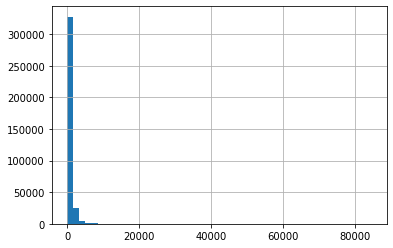

In [42]:
visits['session_duration_sec'].hist(bins=50)

plt.show()

Средняя длительность сессии составляет 715 секунд, это почти 12 минут. Но при взгляде на график распеределения сессий видно что это среднее обусловлено огромными выбросами. Они и утягивают среднее вверх. Мода же продолжительности сессии - 60 секунд, в 12 раз меньше среднего. Очевидно что пользователи заходят на сайт с конкретной целью и достигают ее за минуту пребывания на нем. 

#### _Как часто люди возвращаются? (Retention rate)_

In [43]:
first_session_date = visits.groupby('uid')['start_ts'].min()
first_session_date.name = 'first_session_date'

In [44]:
visits = visits.merge(first_session_date, on='uid')

In [45]:
visits['first_session_month'] = visits['first_session_date'].astype('datetime64[M]')

In [46]:
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')

In [47]:
visits['cohort_lifetime'] = visits['session_month'] - visits['first_session_month']

In [48]:
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')

In [49]:
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

In [50]:
cohorts_rr = visits.groupby(['first_session_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

In [51]:
initial_users_count = cohorts_rr[cohorts_rr['cohort_lifetime'] == 0][['first_session_month','uid']]

In [52]:
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

In [53]:
cohorts_rr = cohorts_rr.merge(initial_users_count, on='first_session_month')

In [54]:
cohorts_rr['retention'] = cohorts_rr['uid'] / cohorts_rr['cohort_users']

In [55]:
rr_pivot = cohorts_rr.pivot_table(index='first_session_month',
                                      columns='cohort_lifetime',
                                      values='retention',
                                      aggfunc='sum')

In [56]:
rr_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_session_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


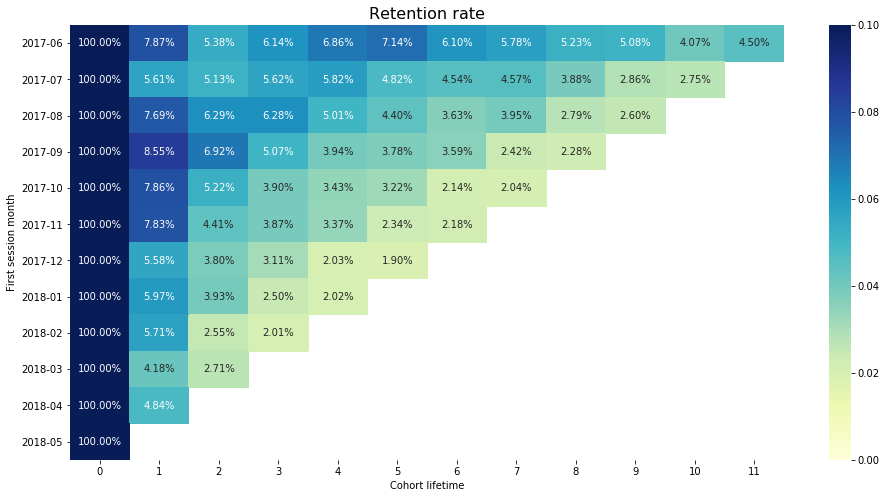

In [57]:
plt.figure(figsize=(16,8))

yticks = pd.period_range(start='2017-06-01', end='2018-05-01', freq='M')

sns.heatmap(rr_pivot, annot=True, yticklabels=yticks, fmt='.2%', vmin=0, vmax=0.1, cmap="YlGnBu")

plt.title('Retention rate', fontdict={'size':16})
plt.ylabel('First session month')
plt.xlabel('Cohort lifetime')

plt.show()

### Итоговые метрики

Среднее количество уникальных пользователей в день = 907  
Среднее количество уникальных пользователей в неделю = 5716  
Среднее количество уникальных пользователей в месяц = 23228

Среднее количество сессий в день = 987  
Среднее количество сессий в день на пользователя = 1.08  

Мода продолжительности сессии (с) = 60

По графику Retention rate видно что коэффициент возврата новых когорт падает гораздо быстрее чем у старых. Если у июньской когорты коэффиент возврата пользователей на 11 месяц составляет 4.5%, то у февральской на 3 месяц уже 2%. Новые пользователи меньше возвращаются на сайт.

### _Продажи_

#### _Когда люди начинают покупать?_

In [58]:
first_purchase = orders.groupby('uid')['buy_ts'].min().to_frame().reset_index()
first_purchase.columns = ['uid','first_purchase']

In [59]:
first_session = visits.loc[:,['uid','start_ts']].groupby('uid')['start_ts'].min().to_frame().reset_index()
first_session.columns = ['uid', 'first_session']

In [60]:
time_to_purchase = first_session.merge(first_purchase, on='uid')

In [61]:
time_to_purchase['time_to_purchase'] = time_to_purchase['first_purchase'] - time_to_purchase['first_session']

In [62]:
time_to_purchase

,uid,first_session,first_purchase,time_to_purchase
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,106 days 23:02:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0 days 00:00:00
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,0 days 01:19:00
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,0 days 19:44:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0 days 00:00:00
...,...,...,...,...
36518,18445147675727495770,2017-08-20 13:30:00,2017-11-24 09:03:00,95 days 19:33:00
36519,18445407535914413204,2017-09-22 23:48:00,2017-09-22 23:55:00,0 days 00:07:00
36520,18445601152732270159,2017-08-07 11:51:00,2018-03-26 22:54:00,231 days 11:03:00
36521,18446156210226471712,2017-11-07 10:01:00,2018-02-18 19:34:00,103 days 09:33:00


In [63]:
time_to_purchase['time_to_purchase'].describe()

count                      36523
mean     16 days 21:40:10.550064
std      47 days 01:44:46.481416
min              0 days 00:00:00
25%              0 days 00:04:00
50%              0 days 00:16:00
75%              2 days 00:17:00
max            363 days 07:04:00
Name: time_to_purchase, dtype: object

50% покупателей совершают свою первую покупку в течение 16 минут после захода на сайт. Вероятно у них есть конкретная цель и они её быстро достигают. Еще 25% платят в течение следующих 2 суток. Оставшиеся 25% покупателей растягивают платеж в течение следующего года.

#### _Сколько раз покупают за период?_

In [64]:
unique_buyers = orders['uid'].nunique()

In [65]:
unique_buyers

36523

In [66]:
repeated_purchase_all = orders.groupby('uid')['buy_ts'].count().mean()

In [67]:
repeated_purchase_all

1.3803630588943954

In [68]:
orders_repeated = orders.copy()

In [69]:
orders_repeated['purchase_month'] = orders_repeated['buy_ts'].dt.month

In [70]:
first_month = orders_repeated.groupby('uid').agg({'purchase_month':'min'}).reset_index()
first_month.columns = ['uid','first_purchase_month']

In [71]:
orders_repeated = orders_repeated.merge(first_month, on='uid')

In [72]:
repeated_purchase_old = (orders_repeated
                         .query('6 <= first_purchase_month <= 11')
                         .groupby('uid')['buy_ts'].count().mean()
                        )

In [73]:
repeated_purchase_old

1.2319899077086516

In [74]:
repeated_purchase_new = (orders_repeated
                         .query('first_purchase_month == [12,1,2,3,4,5]')
                         .groupby('uid')['buy_ts'].count().mean()
                        )

In [75]:
repeated_purchase_new

1.4844842046407605

Средний показатель повторных покупок для всех когорт составляет 38%.  

Но если посмотреть в разрезе старых и новых когорт, то видно что старые покупают вдвое реже чем новые, 23% против 48%.
При том что пользователи из новых когорт реже возвращаются, они чаще покупают.  

Интересно узнать почему меняется покупательское поведение пользователей с течением времени.

#### _Какой средний чек?_

In [76]:
orders['revenue'].mean()

4.999646930477041

In [77]:
orders['revenue'].median()

2.5

In [78]:
orders['revenue'].mode()

0    1.83
dtype: float64

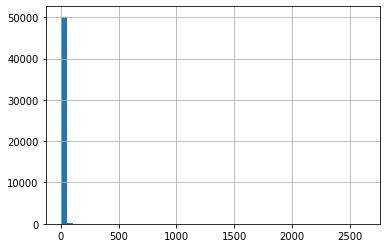

In [79]:
orders['revenue'].hist(bins=50)

plt.show()

In [80]:
orders['revenue'].sort_values(ascending=False).head(10)

23244    2633.28
36522    1236.28
36682    1221.37
23165    1195.64
24607    1109.10
47507    1080.44
40386    1073.11
45653     948.44
40020     856.78
40643     685.67
Name: revenue, dtype: float64

In [81]:
orders['revenue'].value_counts().head(10)

1.83    2552
2.44    2464
3.67    2421
1.22    2216
3.05    2041
4.89    1664
0.61    1312
4.28    1235
6.11    1164
7.33    1150
Name: revenue, dtype: int64

In [82]:
len(orders[orders['revenue'] > 10]) / len(orders)

0.08233660616879897

Средний чек покупки для всех пользователей составляет 5, но это значение сильно обусловлено выбросами. 8.2% покупок стоят более 10, при том что первые 7 самых больших покупок стоят более 1000, они и утягивают среднее к большему значению. Медианное значение - 2.5, уже близкое к моде и его можно считать релевантным.  

1.83, 2.44, 3.67 - суммы покупок, которые чаще встречаются - отлично отражают характер покупок на сайте.

#### _Сколько денег приносят? (LTV)_

In [83]:
orders['purchase_month'] = orders['buy_ts'].astype('datetime64[M]')
orders = orders[orders['purchase_month'] != '2018-06-01']

In [84]:
first_orders = orders.groupby('uid').agg({'purchase_month':'min'}).reset_index()
first_orders.columns = ['uid','first_purchase_month']

In [85]:
cohort_sizes_ltv = first_orders.groupby('first_purchase_month').agg({'uid':'nunique'}).reset_index()
cohort_sizes_ltv.columns = ['first_purchase_month', 'buyers_count']

In [86]:
new_orders = pd.merge(orders, first_orders, on='uid')

In [87]:
cohorts_ltv = new_orders.groupby(['first_purchase_month', 'purchase_month']).agg({'revenue':'sum'}).reset_index()

In [88]:
report_ltv = pd.merge(cohort_sizes_ltv, cohorts_ltv, on='first_purchase_month')

In [89]:
report_ltv['age'] = (report_ltv['purchase_month'] - report_ltv['first_purchase_month']) / np.timedelta64(1,'M')

In [90]:
report_ltv['age'] = report_ltv['age'].round().astype('int')

In [91]:
report_ltv['ltv'] = report_ltv['revenue'] / report_ltv['buyers_count']

In [92]:
ltv_pivot = report_ltv.pivot_table(index='first_purchase_month',
                               columns='age',
                               values='ltv',
                               aggfunc='mean').cumsum(axis=1)

In [93]:
ltv_pivot

age,0,1,2,3,4,5,6,7,8,9,10,11
first_purchase_month,,,,,,,,,,,,
2017-06-01,4.724414,5.209743,5.647380,6.602051,7.624582,8.360084,9.310524,9.892116,10.445329,11.051117,11.622378,11.879234
2017-07-01,6.010218,6.345429,6.968960,7.327936,7.504727,7.660775,7.780983,7.922803,8.084035,8.231180,8.386854,NaN
2017-08-01,5.276518,5.748511,6.206993,6.598270,7.092321,7.375861,7.586526,7.991533,8.283745,8.471723,NaN,NaN
2017-09-01,5.644529,6.762115,7.283045,11.258838,11.659396,12.306463,13.008071,13.251220,13.435227,NaN,NaN,NaN
2017-10-01,5.003733,5.539495,5.730889,5.888035,6.039594,6.159956,6.244772,6.360242,NaN,NaN,NaN,NaN
2017-11-01,5.154683,5.553916,5.753472,6.078424,6.226437,6.280316,6.395244,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.738191,4.998565,5.923662,6.988937,7.301866,7.639913,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.135636,4.430394,4.734675,4.877453,4.940151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.156987,4.435262,4.513777,4.587921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


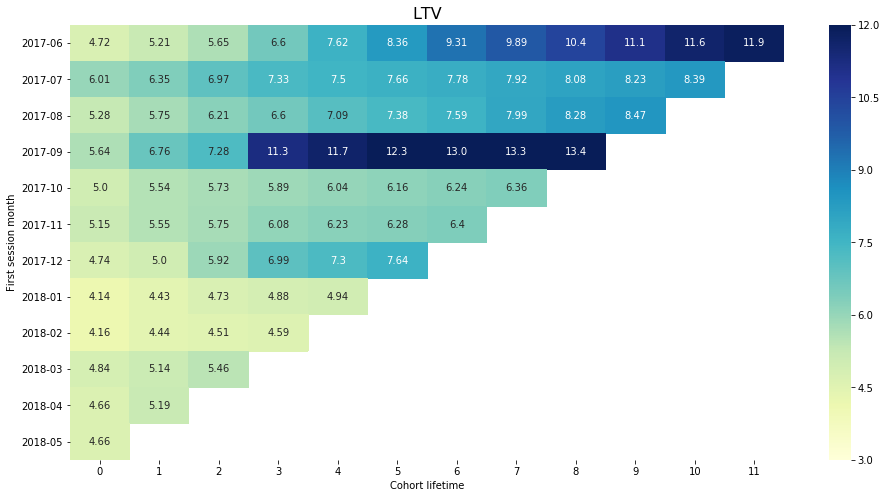

In [94]:
plt.figure(figsize=(16,8))

yticks = pd.period_range(start='2017-06-01', end='2018-05-01', freq='M')

sns.heatmap(ltv_pivot, annot=True, yticklabels=yticks, fmt='.3', vmin=3, vmax=12, cmap="YlGnBu")

plt.title('LTV', fontdict={'size':16})
plt.ylabel('First session month')
plt.xlabel('Cohort lifetime')

plt.show()

График среднего LTV клиента выглядит достаточно однородно для всех когорт, однако есть несколько месяцев когда клиенты заплатили больше ожидаемого. Самый выделяющийся случай произошел с сентябрьской когортой на 3 месяц ее жизни. Вполне возможно что кто-то совершил единовременную большую покупку, тем самым утянув среднее так высоко.

In [95]:
ltv_pivot.mean(axis=0)

age
0      4.916823
1      5.395666
2      5.821811
3      6.689763
4      7.298634
5      7.969053
6      8.387686
7      9.083583
8     10.062084
9      9.251340
10    10.004616
11    11.879234
dtype: float64

По итогу 5 месяца жизни первых 7 когорт (проживших минимум 6 месяцев) видно что в среднем каждый покупатель принес сервису 7.96 единиц выручки. При этом на среднее значение сильное влияние оказали декабрьские выбросы - дорогие покупки. В темпах изменения LTV последовательных когорт прослеживается снижение среднего значения (исключая выброс), однако последний рассматриваемый месяц жизни когорт (5ый) показал рост до 2 по величине значения. Сложно сделать однозначный вывод что послужило причиной роста LTV в этот период, беря во внимание тот факт что последующие когорты набирают LTV с меньшим темпом.

In [96]:
orders.query('purchase_month == "2017-12-01"')['revenue'].max()

2633.28

In [97]:
orders.query('purchase_month == "2017-12-01"').sort_values('revenue', ascending=False).head(10)

,buy_ts,revenue,uid,purchase_month
23244,2017-12-10 20:17:00,2633.28,5539673724080479777,2017-12-01
23165,2017-12-10 13:04:00,1195.64,5539673724080479777,2017-12-01
24607,2017-12-17 18:06:00,1109.10,11149926373378902217,2017-12-01
24341,2017-12-15 21:22:00,604.39,5539673724080479777,2017-12-01
21961,2017-12-05 00:50:00,402.72,5539673724080479777,2017-12-01
21298,2017-12-01 11:59:00,378.89,17999372575896145244,2017-12-01
22769,2017-12-08 12:25:00,360.55,5539673724080479777,2017-12-01
21906,2017-12-04 18:40:00,344.36,5539673724080479777,2017-12-01
24775,2017-12-18 19:07:00,337.33,5539673724080479777,2017-12-01
25480,2017-12-22 19:43:00,304.94,5539673724080479777,2017-12-01


По срезу выше видно, что 3 из 7 покупок стоимостью более 1000 были совершены в этот (предновогодний месяц). Они и подняли средний LTV до значения 3.98. Еще одно место для детального анализа, на какие услуги и для кого были совершены эти покупки.

### _Маркетинг_

In [98]:
costs['month'] = costs['dt'].astype('datetime64[M]')

#### _Сколько денег потратили всего?_

In [99]:
costs['costs'].sum()

329131.62

#### _Сколько денег потратили на каждый источник?_

In [100]:
source_price = costs.groupby('source_id').agg({'costs':'sum'})

In [101]:
source_price['costs'] = source_price['costs'].round().astype('int')

In [102]:
source_price.sort_values('costs', inplace=True)

In [103]:
source_price.reset_index(inplace=True)

In [104]:
source_price['%'] = source_price['costs'] / source_price['costs'].sum()

In [105]:
source_price

,source_id,costs,%
0,9,5517,0.016762
1,10,5822,0.017689
2,1,20833,0.063297
3,2,42806,0.130058
4,5,51757,0.157253
5,4,61074,0.185561
6,3,141322,0.429379


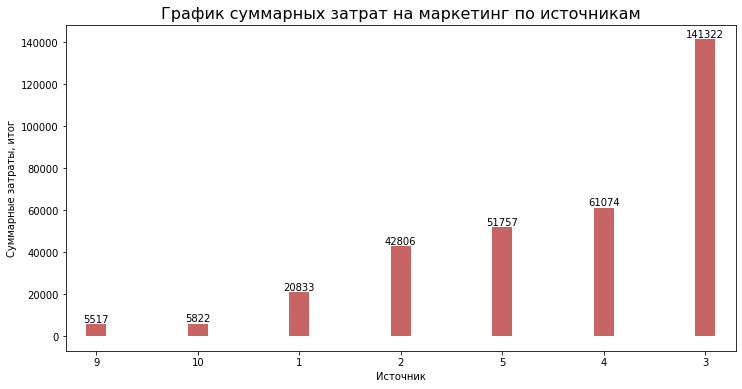

In [106]:
fig, ax = plt.subplots(figsize=(12,6))

ax.vlines(x=source_price.index, ymin=0, ymax=source_price.costs, color='firebrick', alpha=0.7, linewidth=20)

for row in source_price.itertuples():
    ax.text(row.Index, 
            row.costs+.5, 
            s=round(row.costs, 2),
            horizontalalignment='center',
            verticalalignment='bottom',
            fontsize=10)

ax.set_title('График суммарных затрат на маркетинг по источникам', fontdict={'size':16})
ax.set_ylabel('Суммарные затраты, итог')
plt.xticks(source_price.index, source_price.source_id)
ax.set_xlabel('Источник')    

plt.show()

По графику распределния бюджета на рекламные каналы хорошо видно структуру расходов:
 - 43% всего рекламного бюджета тратится на 3 канал,
 - 13-18% на 2,4,5 каналы, 
 - 6% на 1 канал, 
 - 1% на 9 и 10 каналы. 
    
Достаточно неравномерное распределение бюджета по каналам привлечения пользователей. Беря во внимание рассчитанную далее эффективность каждого канала, такие траты на 3 канал вызвают много вопросов.

#### _Сколько денег потратили по времени?_

In [107]:
month_price = costs.groupby('month').agg({'costs':'sum'})

In [108]:
month_price['costs'] = month_price['costs'].round().astype('int')

In [109]:
month_price['%'] = month_price['costs'] / month_price['costs'].sum()

In [110]:
month_price

,costs,%
month,,
2017-06-01,18015,0.054735
2017-07-01,18241,0.055422
2017-08-01,14791,0.044939
2017-09-01,24369,0.074040
2017-10-01,36323,0.110360
2017-11-01,37908,0.115176
2017-12-01,38315,0.116412
2018-01-01,33519,0.101841
2018-02-01,32723,0.099422


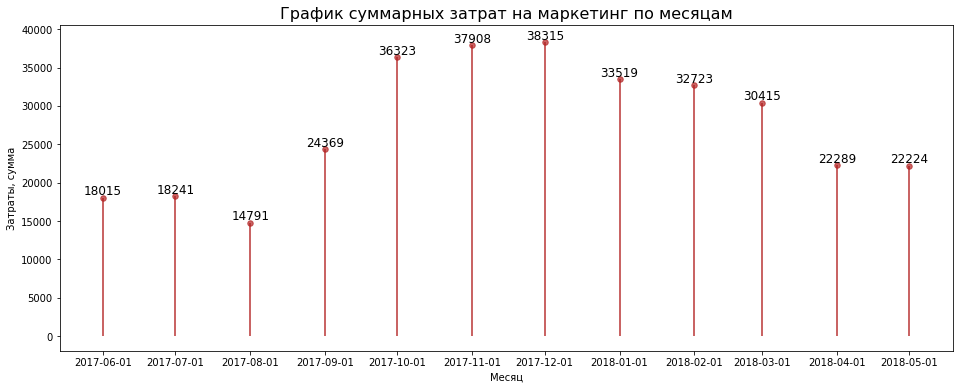

In [111]:
fig, ax = plt.subplots(figsize=(16,6))
                       
ax.vlines(x=month_price.index, ymin=0, ymax=month_price['costs'], color='firebrick', alpha=0.7, linewidth=2)
ax.scatter(x=month_price.index, y=month_price['costs'], s=30, color='firebrick', alpha=0.7)

for row in month_price.itertuples():
    ax.text(row.Index, 
            row.costs+.5, 
            s=round(row.costs, 2),
            horizontalalignment='center',
            verticalalignment='bottom',
            fontsize=12)

ax.set_title('График суммарных затрат на маркетинг по месяцам', fontdict={'size':16})
ax.set_ylabel('Затраты, сумма')
ax.set_xticks(month_price.index)
ax.set_xlabel('Месяц')

plt.show()

По графику распределения рекламного бюджета по месяцам такого большого разброса как в случае с каналами не наблюдается, зато прослеживается "сезонность". С октября по март траты на маркетинг 1.5-2.5 раза выше чем в остальные месяцы. Скорее всего это связано с тем что люди в холодное время года посещают больше мероприятий, а в летнее чаще отдыхают на природе.

#### _Сколько стоило привлечение одного покупателя из каждого источника?_

In [112]:
costs_per_source = costs.groupby('source_id').agg({'costs':'sum'}).reset_index()

In [113]:
source = visits.loc[visits.groupby('uid')['start_ts'].idxmin()]

In [114]:
source = source.loc[:,['uid','source_id']]
source.columns = ['uid','source_id_first_visit']

In [115]:
buyers = orders.groupby('uid')['revenue'].sum().reset_index()

In [116]:
buyers_by_source = (pd
                     .merge(buyers, source, on='uid', how='inner')
                     .groupby('source_id_first_visit')
                     .agg({'uid':'count'})
                     .reset_index()
                    )
buyers_by_source.columns = ['source_id', 'buyers_count']

In [117]:
price_per_buyer_by_source = pd.merge(costs_per_source, buyers_by_source, on='source_id', how='outer')
price_per_buyer_by_source.columns = ['source_id','total_costs','buyers_count']

In [118]:
price_per_buyer_by_source['cost_per_buyer'] = (price_per_buyer_by_source['total_costs'] / 
                                               price_per_buyer_by_source['buyers_count'])

In [119]:
price_per_buyer_by_source

,source_id,total_costs,buyers_count,cost_per_buyer
0,1,20833.27,2899,7.186364
1,2,42806.04,3506,12.209367
2,3,141321.63,10473,13.493901
3,4,61073.60,10295,5.932356
4,5,51757.10,6931,7.467479
5,9,5517.49,1088,5.071222
6,10,5822.49,1329,4.381106
7,7,NaN,1,NaN


In [120]:
price_per_buyer_by_source = price_per_buyer_by_source.loc[0:6]

In [121]:
price_per_buyer_by_source.sort_values('cost_per_buyer', inplace=True)

In [122]:
price_per_buyer_by_source.reset_index(inplace=True)

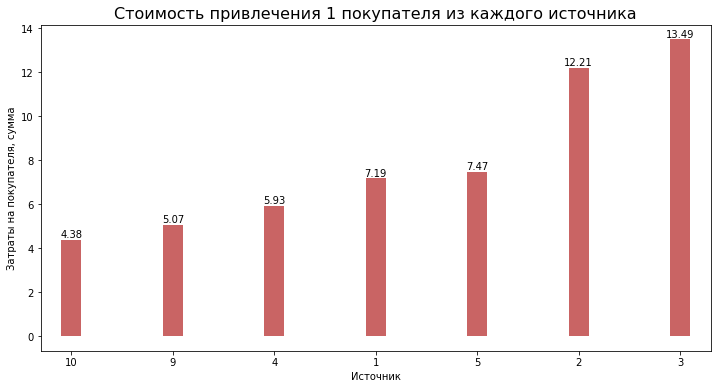

In [123]:
fig, ax = plt.subplots(figsize=(12,6))

ax.vlines(x=price_per_buyer_by_source.index, 
          ymin=0, 
          ymax=price_per_buyer_by_source.cost_per_buyer, 
          color='firebrick', 
          alpha=0.7, 
          linewidth=20)

for row in price_per_buyer_by_source.itertuples():
    ax.text(row.Index, 
            row.cost_per_buyer,
            s=round(row.cost_per_buyer, 2),
            horizontalalignment='center',
            verticalalignment='bottom',
            fontsize=10)
    
ax.set_title('Стоимость привлечения 1 покупателя из каждого источника', fontdict={'size':16})
ax.set_ylabel('Затраты на покупателя, сумма')
plt.xticks(price_per_buyer_by_source.index, price_per_buyer_by_source.source_id)
ax.set_xlabel('Источник')    

plt.show()

Рекламные каналы по стоимости привлечения покупателя можно условно разделить на 2 группы:
 - в 1, "дешевую", группу войдут каналы 1,4,5,9,10 со стоимостью привлечения 4.38-7.47 единиц;
 - во 2, "дорогую", каналы 2 и 3. 
    
Канал 3 лидирует как по объему бюджета расходуемого на этот канал, так и по стоимости привлечения целевых клиентов - покупателей. Забегая немного вперед, зная показатель ROI покупателей пришедших из этого канала, где максимальное значение чуть больше 0.5, стоит найти вескую причину продолжить использовать этот канал, который на протяжении всего исследуемого периода работает в минус.

#### _На сколько окупились расходы? (ROI)_

In [124]:
monthly_costs = costs.groupby('month')['costs'].sum()

In [125]:
report_roi = pd.merge(report_ltv, monthly_costs, left_on='first_purchase_month', right_on='month')

In [126]:
report_roi['cac'] = report_roi['costs'] / report_roi['buyers_count']

In [127]:
report_roi['roi'] = report_roi['ltv'] / report_roi['cac']

In [128]:
roi_pivot = report_roi.pivot_table(index='first_purchase_month',
                                   columns='age',
                                   values='roi',
                                   aggfunc='mean').cumsum(axis=1)

In [129]:
roi_pivot

age,0,1,2,3,4,5,6,7,8,9,10,11
first_purchase_month,,,,,,,,,,,,
2017-06-01,0.530530,0.585030,0.634174,0.741379,0.856205,0.938798,1.045528,1.110838,1.172961,1.240989,1.305138,1.333982
2017-07-01,0.633623,0.668962,0.734697,0.772542,0.791180,0.807631,0.820304,0.835255,0.852253,0.867766,0.884178,NaN
2017-08-01,0.488747,0.532466,0.574934,0.611176,0.656939,0.683202,0.702715,0.740230,0.767297,0.784708,NaN,NaN
2017-09-01,0.597833,0.716200,0.771374,1.192464,1.234889,1.303422,1.377732,1.403485,1.422974,NaN,NaN,NaN
2017-10-01,0.597866,0.661881,0.684749,0.703525,0.721634,0.736016,0.746150,0.759947,NaN,NaN,NaN,NaN
2017-11-01,0.554931,0.597911,0.619394,0.654377,0.670312,0.676112,0.688485,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.542015,0.571800,0.677624,0.799484,0.835281,0.873951,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.416173,0.445835,0.476455,0.490823,0.497132,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.463807,0.494855,0.503615,0.511887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


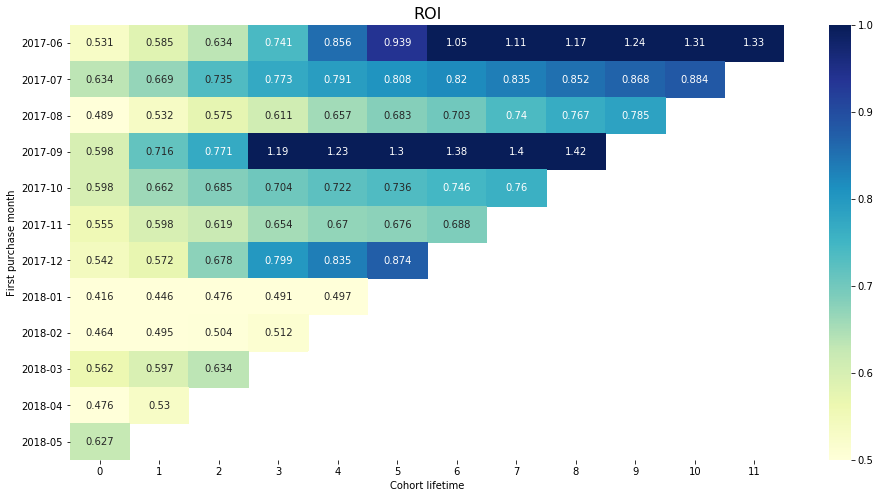

In [130]:
plt.figure(figsize=(16,8))

yticks = pd.period_range(start='2017-06-01', end='2018-05-01', freq='M')

sns.heatmap(roi_pivot, annot=True, yticklabels=yticks, fmt='.3', vmin=0.5, vmax=1, cmap="YlGnBu")

plt.title('ROI', fontdict={'size':16})
plt.ylabel('First purchase month')
plt.xlabel('Cohort lifetime')

plt.show()

По графику ROI видно что за весь год окупились только 2 когорты пользователей. Первая, июньская, которга окупилась на 6 месяц жизни. Стоит отметить что у этой когорты самый высокий Retention rate. Ее окупаемость выглядит органической, ROI нарастает ровномерно в течение всего периода жизни когорты. Вторая окупившаяся когорта - сентябрьская. Окупилась она на 3 месяц и только из-за чрезвычайно высоких покупок, которые не вписываются в типичное поведение пользователей на сайте.  

В целом ситуация по году выглядит нерадужно. Инвестиции на привлечение пользователей окупаются слабо. В новых когортах ROI показывает очень низкий темп нарастания. Беря во внимание информацию о 2 предыдущих показателях (RR и LTV) можно сделать вывод что цикл жизни нового пользователя на сайте сокращается. При том что покупок они делают больше, они же и реже возвращаются получив искомую услугу.  

Сентябрьская когорта выглядит эталонной, ее обязательно стоит изучить максимально детально со всех точек зрения чтобы идентифицировать органичное и выгодное поведение пользователя.  

Далее я буду рассматривать подробнее показатели LTV и ROI по покупателям придешним из каждого рекламного канала, для более аргументированного ответа.

In [131]:
roi_pivot.mean(axis=0)

age
0     0.540816
1     0.581985
2     0.631069
3     0.719740
4     0.782946
5     0.859876
6     0.896819
7     0.969951
8     1.053871
9     0.964488
10    1.094658
11    1.333982
dtype: float64

По итогу 6 месяцев, для когорт проживших этот срок, средний показатель ROI составляет 0.86. Только 1 когорта пользователей окупилась за этот период.  
На общем показателе ROI сказывается влияние неэффективных рекламных расходов.

#### _Изменение стоимости привлечения 1 покупателя из каждого источника по месяцам_

In [132]:
customer_cost = costs.groupby(['source_id','month']).agg({'costs':'sum'}).reset_index()

In [133]:
source_1 = visits.loc[visits.groupby('uid')['start_ts'].idxmin()]

In [134]:
source_1 = source_1.loc[:,['uid','source_id','session_month']]
source_1.columns = ['uid','source_id_first_visit','session_month']

In [135]:
buyers_1 = orders.groupby('uid')['revenue'].sum().reset_index()

In [136]:
buyers_by_source_1 = (pd.merge(buyers_1, source_1, on='uid', how='inner')
                      .groupby(['source_id_first_visit','session_month']).agg({'uid':'count'})
                      .reset_index()
                     )
                   
buyers_by_source_1.columns = ['source_id','month', 'buyers_count']

In [137]:
customer_cost_by_source = pd.merge(buyers_by_source_1, customer_cost, on=['source_id','month'], how='outer')

In [138]:
customer_cost_by_source['cac'] = customer_cost_by_source['costs'] / customer_cost_by_source['buyers_count']

In [139]:
customer_cost_by_source.pivot_table(index='month',
                                    columns='source_id',
                                    values='cac')

source_id,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,4.690042,6.490321,8.726467,5.432457,5.139725,1.852078,2.780708
2017-07-01,5.830870,8.392482,11.540406,5.236988,6.044637,3.025400,5.406885
2017-08-01,7.554048,12.490000,13.743937,7.715492,5.000641,2.416796,5.168222
2017-09-01,6.056492,11.224286,10.543439,7.438768,5.602824,3.522203,4.798646
2017-10-01,6.616429,11.535714,12.440506,5.016281,5.643249,5.036446,2.851091
2017-11-01,7.387190,12.768078,13.405780,4.203448,9.357012,4.436234,5.741739
2017-12-01,7.137805,14.664072,13.371410,5.949241,7.925128,7.151957,8.611467
2018-01-01,9.847658,16.901382,15.855225,5.976219,9.213585,9.948364,5.964563
2018-02-01,8.679055,17.077634,14.945966,6.025274,8.382331,10.605769,4.255575


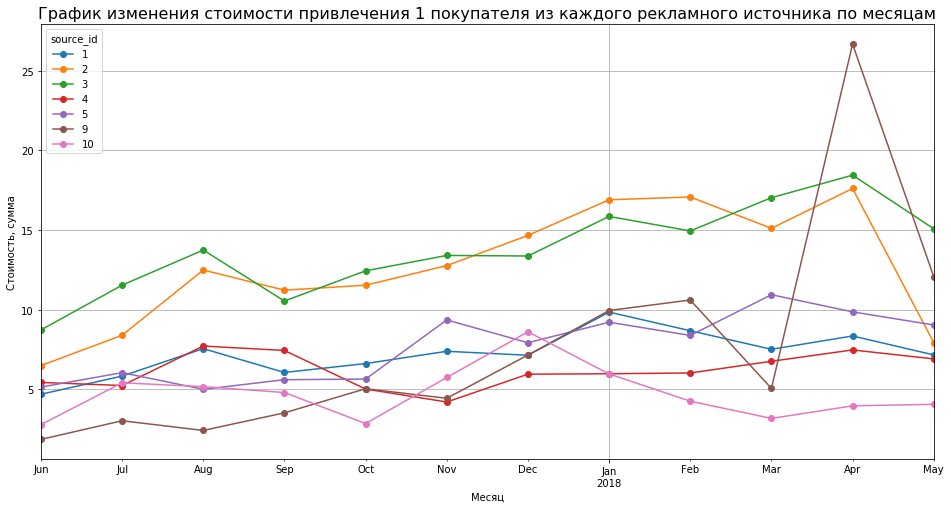

In [140]:
(customer_cost_by_source
 .pivot_table(index='month', 
              columns='source_id',
              values='cac')
 .plot(figsize=(16,8),
       style='-o',
       grid=True)
)

plt.title('График изменения стоимости привлечения 1 покупателя из каждого рекламного источника по месяцам', fontdict={'size':16})
plt.xlabel('Месяц')
plt.ylabel('Стоимость, сумма')

plt.show()

По графику изменения стоимости привлечения покупателя видно что все каналы трафика растут в цене в течение года.
    
Так же на графике изображен резкий скачок цены 9 канала в апреле 2018 г. Мне сложно дать адекватную оценку этому событию, не зная дополнитльной информации.
    
На мой взгляд эффективнее оценивать не абсолютный прирост цены,а относительный, то есть темп роста. Годовой и месячный. Например, становится очевидным тот факт что стоимость покупателя из 3 канала выросла за год почти в 2 раза. Остальные каналы тоже выросли, но с учетом объема расходуемых на него средств и темпом роста стоимости покупателя, этот канала теряет привлекательность.

#### _Изменение LTV и ROI по источникам_

In [141]:
orders_by_source = pd.merge(orders, source, on='uid')

_Рекламный источник 1_

In [142]:
source_1 = orders_by_source.loc[orders_by_source['source_id_first_visit'] == 1]

In [143]:
first_orders_1 = source_1.groupby('uid').agg({'purchase_month':'min'}).reset_index()
first_orders_1.columns = ['uid','first_purchase_month']

In [144]:
cohort_sizes_1 = first_orders_1.groupby('first_purchase_month').agg({'uid':'nunique'}).reset_index()
cohort_sizes_1.columns = ['first_purchase_month', 'buyers_count']

In [145]:
new_orders_1 = pd.merge(source_1, first_orders_1, on='uid')

In [146]:
cohorts_1 = new_orders_1.groupby(['first_purchase_month', 'purchase_month']).agg({'revenue':'sum'}).reset_index()

In [147]:
report_1 = pd.merge(cohort_sizes_1, cohorts_1, on='first_purchase_month')

In [148]:
report_1['age'] = (report_1['purchase_month'] - report_1['first_purchase_month']) / np.timedelta64(1,'M')

In [149]:
report_1['age'] = report_1['age'].round().astype('int')

In [150]:
report_1['ltv'] = report_1['revenue'] / report_1['buyers_count']

In [151]:
pivot_1_ltv = report_1.pivot_table(index='first_purchase_month',
                               columns='age',
                               values='ltv',
                               aggfunc='mean').cumsum(axis=1)

In [152]:
pivot_1_ltv

age,0,1,2,3,4,5,6,7,8,9,10,11
first_purchase_month,,,,,,,,,,,,
2017-06-01,7.256316,9.440421,11.647947,15.407105,19.676579,21.725737,24.307211,26.829474,29.103947,30.768684,31.973526,33.644158
2017-07-01,7.291875,8.387562,13.742187,15.249187,16.127500,17.027375,17.474250,18.120375,18.977438,19.962813,20.890750,NaN
2017-08-01,7.493363,8.690619,9.700885,10.665664,11.704956,12.371327,13.051504,15.708673,17.901858,18.680619,NaN,NaN
2017-09-01,6.014714,7.816520,8.375815,9.300661,9.339427,9.434758,9.519736,9.826608,10.416520,NaN,NaN,NaN
2017-10-01,6.018618,7.074441,7.319206,7.707029,7.770294,7.878500,8.061824,8.382588,NaN,NaN,NaN,NaN
2017-11-01,7.390895,7.964691,8.928272,9.822191,9.985463,10.091420,10.172130,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.584290,4.895317,5.184079,5.429789,5.456375,5.551994,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,5.768824,5.859328,6.003866,6.977227,7.026513,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.686545,5.686400,5.753745,6.123273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


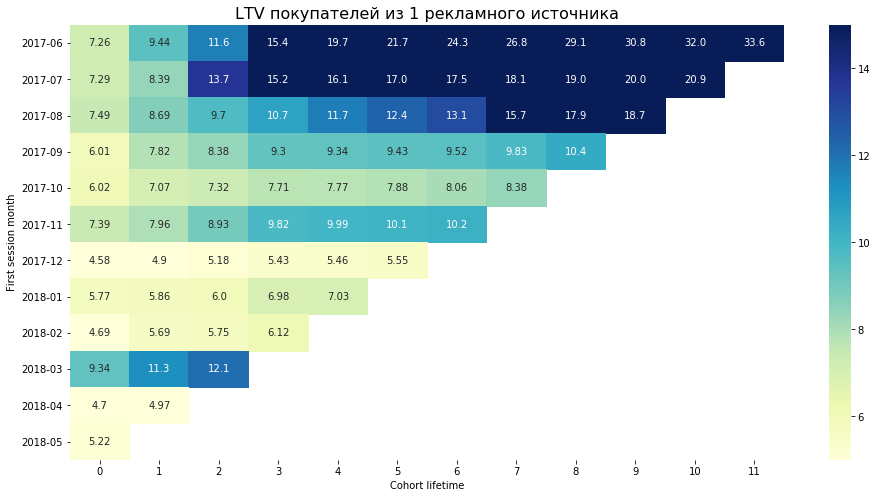

In [153]:
plt.figure(figsize=(16,8))

yticks = pd.period_range(start='2017-06-01', end='2018-05-01', freq='M')

sns.heatmap(pivot_1_ltv, annot=True, yticklabels=yticks, fmt='.3', vmin=5, vmax=15, cmap="YlGnBu")

plt.title('LTV покупателей из 1 рекламного источника', fontdict={'size':16})
plt.ylabel('First session month')
plt.xlabel('Cohort lifetime')

plt.show()

In [154]:
costs_1 = costs.loc[costs['source_id'] == 1].groupby(['source_id','month']).agg({'costs':'sum'})

In [155]:
report_1 = report_1.merge(costs_1, left_on='first_purchase_month', right_on='month')

In [156]:
report_1['cac'] = report_1['costs'] / report_1['buyers_count']

In [157]:
report_1['roi'] = report_1['ltv'] / report_1['cac']

In [158]:
report_1_roi = report_1.pivot_table(index='first_purchase_month',
                                   columns='age',
                                   values='roi',
                                   aggfunc='mean').cumsum(axis=1)

In [159]:
report_1_roi

age,0,1,2,3,4,5,6,7,8,9,10,11
first_purchase_month,,,,,,,,,,,,
2017-06-01,1.224847,1.593518,1.966143,2.600679,3.321355,3.667247,4.102993,4.528744,4.912670,5.193673,5.397047,5.679045
2017-07-01,1.087447,1.250848,2.049390,2.274131,2.405115,2.539315,2.605958,2.702315,2.830130,2.977080,3.115465,NaN
2017-08-01,0.889621,1.031761,1.151700,1.266240,1.389626,1.468739,1.549490,1.864952,2.125330,2.217785,NaN,NaN
2017-09-01,0.909009,1.181317,1.265844,1.405616,1.411475,1.425883,1.438725,1.485103,1.574257,NaN,NaN,NaN
2017-10-01,0.883658,1.038674,1.074611,1.131551,1.140840,1.156727,1.183642,1.230737,NaN,NaN,NaN,NaN
2017-11-01,0.979343,1.055375,1.183056,1.301506,1.323140,1.337180,1.347875,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.648129,0.692102,0.732928,0.767666,0.771425,0.784944,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.628027,0.637880,0.653615,0.759581,0.764946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.584628,0.709355,0.717757,0.763854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


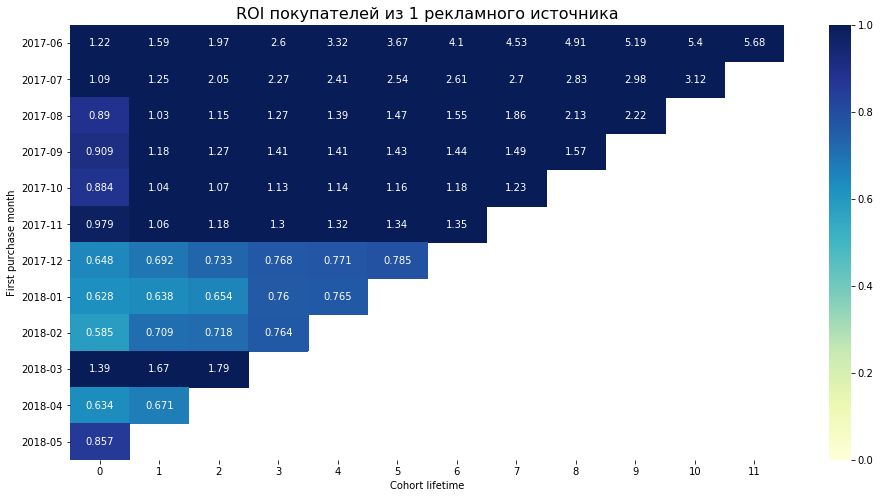

In [160]:
plt.figure(figsize=(16,8))

yticks = pd.period_range(start='2017-06-01', end='2018-05-01', freq='M')

sns.heatmap(report_1_roi, annot=True, yticklabels=yticks, fmt='.3', vmin=0, vmax=1, cmap="YlGnBu")

plt.title('ROI покупателей из 1 рекламного источника', fontdict={'size':16})
plt.ylabel('First purchase month')
plt.xlabel('Cohort lifetime')

plt.show()

In [161]:
report_1_roi.mean(axis=0)

age
0     0.892768
1     1.048742
2     1.258675
3     1.363425
4     1.565990
5     1.768576
6     2.038114
7     2.362370
8     2.860597
9     3.462846
10    4.256256
11    5.679045
dtype: float64

Средний ROI из рассматриваемых 7 когорт пришедших из 1 рекламного канала и проживших 6 месяцев составляет 1.76. Отмечу тот факт что в среднем когорта окупается на 1 месяц жизни. Первые пол года этот рекламный канал работал отлично, начиная в декабря его эффективность снизилась.

_Рекламный источник 2_

In [162]:
source_2 = orders_by_source.loc[orders_by_source['source_id_first_visit'] == 2]

In [163]:
first_orders_2 = source_2.groupby('uid').agg({'purchase_month':'min'}).reset_index()
first_orders_2.columns = ['uid','first_purchase_month']

In [164]:
cohort_sizes_2 = first_orders_2.groupby('first_purchase_month').agg({'uid':'nunique'}).reset_index()
cohort_sizes_2.columns = ['first_purchase_month', 'buyers_count']

In [165]:
new_orders_2 = pd.merge(source_2, first_orders_2, on='uid')

In [166]:
cohorts_2 = new_orders_2.groupby(['first_purchase_month', 'purchase_month']).agg({'revenue':'sum'}).reset_index()

In [167]:
report_2 = pd.merge(cohort_sizes_2, cohorts_2, on='first_purchase_month')

In [168]:
report_2['age'] = (report_2['purchase_month'] - report_2['first_purchase_month']) / np.timedelta64(1,'M')

In [169]:
report_2['age'] = report_2['age'].round().astype('int')

In [170]:
report_2['ltv'] = report_2['revenue'] / report_2['buyers_count']

In [171]:
pivot_2 = report_2.pivot_table(index='first_purchase_month',
                               columns='age',
                               values='ltv',
                               aggfunc='mean').cumsum(axis=1)

In [172]:
pivot_2

age,0,1,2,3,4,5,6,7,8,9,10,11
first_purchase_month,,,,,,,,,,,,
2017-06-01,4.441191,4.932851,5.204766,7.129660,8.796468,9.715447,11.317660,12.799787,14.135106,14.868809,16.227404,16.660681
2017-07-01,8.429663,9.195240,9.254567,9.576346,10.008510,10.194760,10.493606,10.630625,10.741731,10.970769,11.334471,NaN
2017-08-01,5.738862,6.674797,6.853089,7.103984,7.619106,7.682195,7.803902,8.196992,8.230163,8.314553,NaN,NaN
2017-09-01,8.282217,16.410679,18.773122,19.696244,21.104434,22.079367,25.397195,26.150543,26.702760,NaN,NaN,NaN
2017-10-01,7.676364,10.132247,10.793005,11.333005,11.889293,12.155657,12.255328,12.507551,NaN,NaN,NaN,NaN
2017-11-01,6.989347,7.897889,8.335503,9.119070,9.432236,9.575427,9.719849,NaN,NaN,NaN,NaN,NaN
2017-12-01,8.808976,10.351417,19.682467,30.782782,33.827953,37.038031,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.343322,5.433390,7.170616,7.415342,7.744349,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,5.417031,6.064437,6.387611,6.643242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


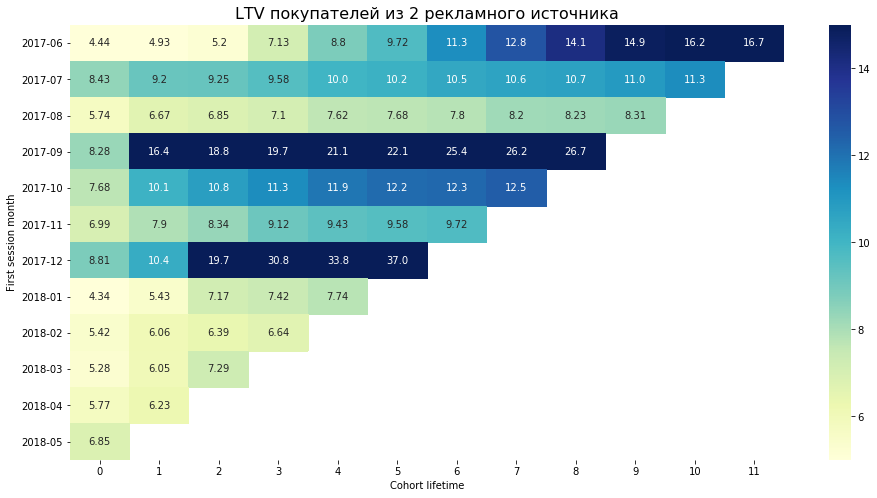

In [173]:
plt.figure(figsize=(16,8))

yticks = pd.period_range(start='2017-06-01', end='2018-05-01', freq='M')

sns.heatmap(pivot_2, annot=True, yticklabels=yticks, fmt='.3', vmin=5, vmax=15, cmap="YlGnBu")

plt.title('LTV покупателей из 2 рекламного источника', fontdict={'size':16})
plt.ylabel('First session month')
plt.xlabel('Cohort lifetime')

plt.show()

In [174]:
costs_2 = costs.loc[costs['source_id'] == 2].groupby(['source_id','month']).agg({'costs':'sum'})

In [175]:
report_2 = report_2.merge(costs_2, left_on='first_purchase_month', right_on='month')

In [176]:
report_2['cac'] = report_2['costs'] / report_2['buyers_count']

In [177]:
report_2['roi'] = report_2['ltv'] / report_2['cac']

In [178]:
report_2_roi = report_2.pivot_table(index='first_purchase_month',
                                   columns='age',
                                   values='roi',
                                   aggfunc='mean').cumsum(axis=1)

In [179]:
report_2_roi

age,0,1,2,3,4,5,6,7,8,9,10,11
first_purchase_month,,,,,,,,,,,,
2017-06-01,0.429962,0.477560,0.503885,0.690238,0.851605,0.940574,1.095688,1.239176,1.368451,1.439482,1.571011,1.612957
2017-07-01,0.751516,0.819768,0.825058,0.853745,0.892273,0.908877,0.935520,0.947735,0.957640,0.978059,1.010484,NaN
2017-08-01,0.389763,0.453328,0.465437,0.482477,0.517462,0.521747,0.530013,0.556710,0.558963,0.564695,NaN,NaN
2017-09-01,0.613054,1.214726,1.389596,1.457926,1.562160,1.634325,1.879913,1.935676,1.976551,NaN,NaN,NaN
2017-10-01,0.627418,0.828147,0.882153,0.926289,0.971756,0.993527,1.001674,1.022289,NaN,NaN,NaN,NaN
2017-11-01,0.530093,0.599000,0.632190,0.691618,0.715369,0.726229,0.737183,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.685251,0.805237,1.531100,2.394593,2.631477,2.881190,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.305034,0.381590,0.503596,0.520783,0.543889,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.354732,0.397127,0.418290,0.435030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


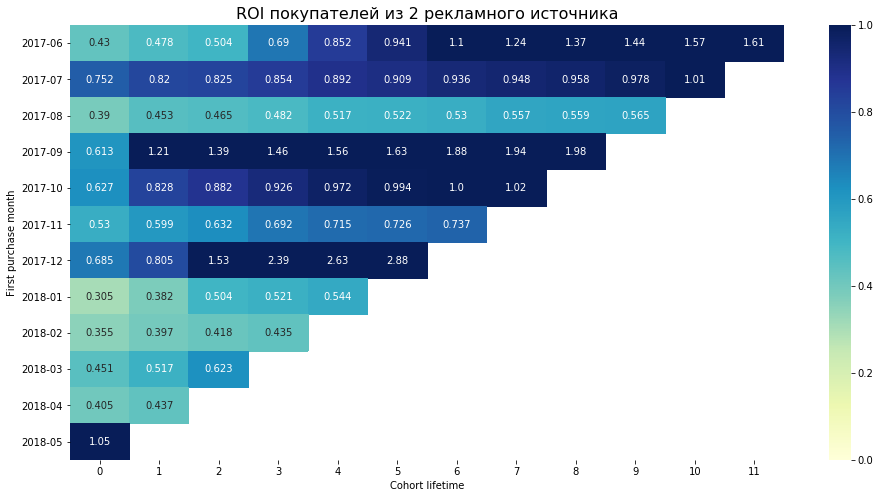

In [180]:
plt.figure(figsize=(16,8))

yticks = pd.period_range(start='2017-06-01', end='2018-05-01', freq='M')

sns.heatmap(report_2_roi, annot=True, yticklabels=yticks, fmt='.3', vmin=0, vmax=1, cmap="YlGnBu")

plt.title('ROI покупателей из 2 рекламного источника', fontdict={'size':16})
plt.ylabel('First purchase month')
plt.xlabel('Cohort lifetime')

plt.show()

In [181]:
report_2_roi.mean(axis=0)

age
0     0.549286
1     0.630051
2     0.777428
3     0.939189
4     1.085749
5     1.229496
6     1.029998
7     1.140317
8     1.215401
9     0.994079
10    1.290747
11    1.612957
dtype: float64

2 рекламный источник показывает себя хуже. Когорты в среднем окупаются на 4 месяц жизни. Спустя пол года окупилась половина когорт.

_Рекламный источник 3_

In [182]:
source_3 = orders_by_source.loc[orders_by_source['source_id_first_visit'] == 3]

In [183]:
first_orders_3 = source_3.groupby('uid').agg({'purchase_month':'min'}).reset_index()
first_orders_3.columns = ['uid','first_purchase_month']

In [184]:
cohort_sizes_3 = first_orders_3.groupby('first_purchase_month').agg({'uid':'nunique'}).reset_index()
cohort_sizes_3.columns = ['first_purchase_month', 'buyers_count']

In [185]:
new_orders_3 = pd.merge(source_3, first_orders_3, on='uid')

In [186]:
cohorts_3 = new_orders_3.groupby(['first_purchase_month', 'purchase_month']).agg({'revenue':'sum'}).reset_index()

In [187]:
report_3 = pd.merge(cohort_sizes_3, cohorts_3, on='first_purchase_month')

In [188]:
report_3['age'] = (report_3['purchase_month'] - report_3['first_purchase_month']) / np.timedelta64(1,'M')

In [189]:
report_3['age'] = report_3['age'].round().astype('int')

In [190]:
report_3['ltv'] = report_3['revenue'] / report_3['buyers_count']

In [191]:
pivot_3 = report_3.pivot_table(index='first_purchase_month',
                               columns='age',
                               values='ltv',
                               aggfunc='mean').cumsum(axis=1)

In [192]:
pivot_3

age,0,1,2,3,4,5,6,7,8,9,10,11
first_purchase_month,,,,,,,,,,,,
2017-06-01,4.395517,4.508323,4.694734,5.005940,5.191646,5.384875,5.512790,5.542398,5.592445,5.645486,5.673652,5.705831
2017-07-01,6.105117,6.367891,6.491680,6.885664,6.925645,6.996621,7.033125,7.165332,7.249434,7.290234,7.345781,NaN
2017-08-01,5.078635,5.233412,5.521365,5.628338,5.790386,5.839674,5.904125,5.996855,6.075549,6.136469,NaN,NaN
2017-09-01,5.563099,5.810858,6.135339,6.222919,6.446773,6.565877,6.693252,6.767273,6.887708,NaN,NaN,NaN
2017-10-01,4.786806,5.243715,5.362786,5.425148,5.533498,5.628550,5.646701,5.720182,NaN,NaN,NaN,NaN
2017-11-01,4.532442,4.667253,4.751464,4.869498,4.924992,4.956653,4.989951,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.178846,4.310706,4.452817,4.578960,4.677525,4.738793,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.114414,4.296392,4.428618,4.507992,4.561302,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,3.787747,4.097399,4.185595,4.246969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


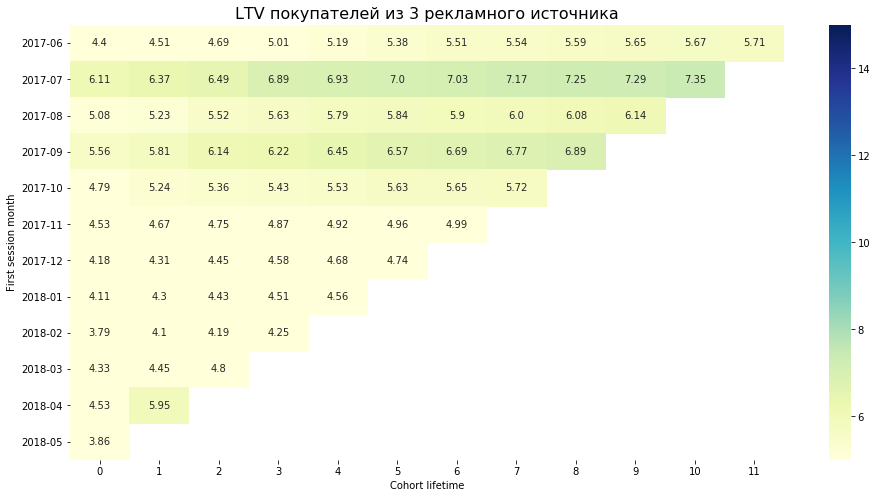

In [193]:
plt.figure(figsize=(16,8))

yticks = pd.period_range(start='2017-06-01', end='2018-05-01', freq='M')

sns.heatmap(pivot_3, annot=True, yticklabels=yticks, fmt='.3', vmin=5, vmax=15, cmap="YlGnBu")

plt.title('LTV покупателей из 3 рекламного источника', fontdict={'size':16})
plt.ylabel('First session month')
plt.xlabel('Cohort lifetime')

plt.show()

In [194]:
costs_3 = costs.loc[costs['source_id'] == 3].groupby(['source_id','month']).agg({'costs':'sum'})

In [195]:
report_3 = report_3.merge(costs_3, left_on='first_purchase_month', right_on='month')

In [196]:
report_3['cac'] = report_3['costs'] / report_3['buyers_count']

In [197]:
report_3['roi'] = report_3['ltv'] / report_3['cac']

In [198]:
report_3_roi = report_3.pivot_table(index='first_purchase_month',
                                   columns='age',
                                   values='roi',
                                   aggfunc='mean').cumsum(axis=1)

In [199]:
report_3_roi

age,0,1,2,3,4,5,6,7,8,9,10,11
first_purchase_month,,,,,,,,,,,,
2017-06-01,0.362709,0.372018,0.387400,0.413080,0.428404,0.444349,0.454904,0.457347,0.461477,0.465854,0.468178,0.470834
2017-07-01,0.407306,0.424837,0.433096,0.459381,0.462048,0.466784,0.469219,0.478039,0.483650,0.486372,0.490078,NaN
2017-08-01,0.278585,0.287076,0.302871,0.308739,0.317628,0.320332,0.323867,0.328954,0.333270,0.336612,NaN,NaN
2017-09-01,0.436067,0.455488,0.480923,0.487788,0.505335,0.514671,0.524655,0.530458,0.539898,NaN,NaN,NaN
2017-10-01,0.350405,0.383851,0.392568,0.397133,0.405064,0.412022,0.413351,0.418730,NaN,NaN,NaN,NaN
2017-11-01,0.323720,0.333349,0.339364,0.347794,0.351757,0.354019,0.356397,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.339316,0.350023,0.361562,0.371804,0.379808,0.384783,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.279503,0.291865,0.300848,0.306240,0.309861,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.290698,0.314463,0.321232,0.325942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


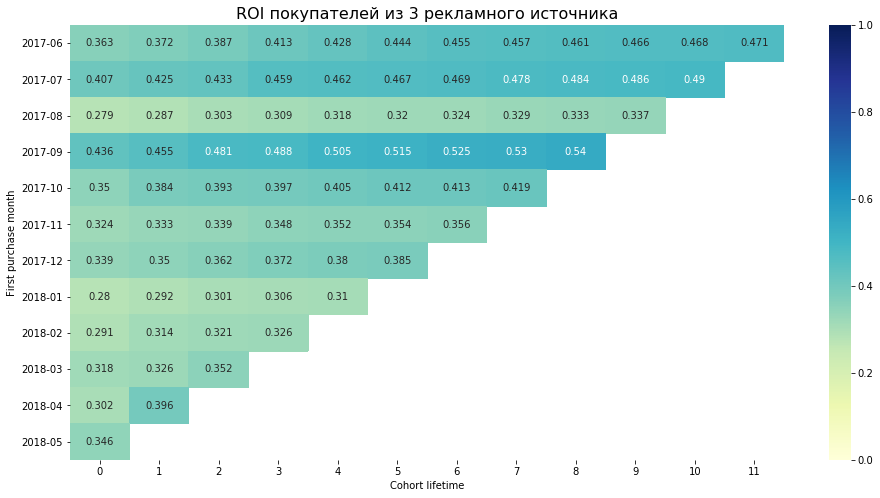

In [200]:
plt.figure(figsize=(16,8))

yticks = pd.period_range(start='2017-06-01', end='2018-05-01', freq='M')

sns.heatmap(report_3_roi, annot=True, yticklabels=yticks, fmt='.3', vmin=0, vmax=1, cmap="YlGnBu")

plt.title('ROI покупателей из 3 рекламного источника', fontdict={'size':16})
plt.ylabel('First purchase month')
plt.xlabel('Cohort lifetime')

plt.show()

In [201]:
report_3_roi.mean(axis=0)

age
0     0.336151
1     0.357750
2     0.367152
3     0.379767
4     0.394988
5     0.413851
6     0.423732
7     0.442706
8     0.454574
9     0.429613
10    0.479128
11    0.470834
dtype: float64

3 источник, как было сказано несколько раз ранее, показывает очень плохие результаты. Ни одна когорта не окупилась за год. От него в 1 очередь необходимо отказаться и перераспределить бюджет на более эффективные каналы привлечения юзеров.

_Рекламный источник 4_

In [202]:
source_4 = orders_by_source.loc[orders_by_source['source_id_first_visit'] == 4]

In [203]:
first_orders_4 = source_4.groupby('uid').agg({'purchase_month':'min'}).reset_index()
first_orders_4.columns = ['uid','first_purchase_month']

In [204]:
cohort_sizes_4 = first_orders_4.groupby('first_purchase_month').agg({'uid':'nunique'}).reset_index()
cohort_sizes_4.columns = ['first_purchase_month', 'buyers_count']

In [205]:
new_orders_4 = pd.merge(source_4, first_orders_4, on='uid')

In [206]:
cohorts_4 = new_orders_4.groupby(['first_purchase_month', 'purchase_month']).agg({'revenue':'sum'}).reset_index()

In [207]:
report_4 = pd.merge(cohort_sizes_4, cohorts_4, on='first_purchase_month')

In [208]:
report_4['age'] = (report_4['purchase_month'] - report_4['first_purchase_month']) / np.timedelta64(1,'M')

In [209]:
report_4['age'] = report_4['age'].round().astype('int')

In [210]:
report_4['ltv'] = report_4['revenue'] / report_4['buyers_count']

In [211]:
pivot_4 = report_4.pivot_table(index='first_purchase_month',
                               columns='age',
                               values='ltv',
                               aggfunc='mean').cumsum(axis=1)

In [212]:
pivot_4

age,0,1,2,3,4,5,6,7,8,9,10,11
first_purchase_month,,,,,,,,,,,,
2017-06-01,4.745375,4.785714,4.956586,5.416005,6.564431,8.053317,9.482639,9.715738,9.932300,10.734939,12.003898,12.088789
2017-07-01,5.544739,5.603830,5.684294,5.844487,5.900445,5.962708,6.064797,6.110058,6.196905,6.257853,6.279729,NaN
2017-08-01,5.064970,5.233639,5.364556,5.631716,5.778018,5.986805,6.069970,6.259497,6.352249,6.475473,NaN,NaN
2017-09-01,4.766678,5.247339,5.560814,5.848898,5.898644,6.135814,7.390525,7.656119,7.707712,NaN,NaN,NaN
2017-10-01,4.367944,4.513899,4.665324,4.777005,4.896220,4.988498,5.076340,5.140776,NaN,NaN,NaN,NaN
2017-11-01,5.143789,5.791240,5.891759,6.297298,6.491742,6.535489,6.756109,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.171975,4.261293,4.353224,4.438889,4.478693,4.564023,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,3.781647,3.902161,3.985165,4.058430,4.088227,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.093382,4.203526,4.238725,4.257233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


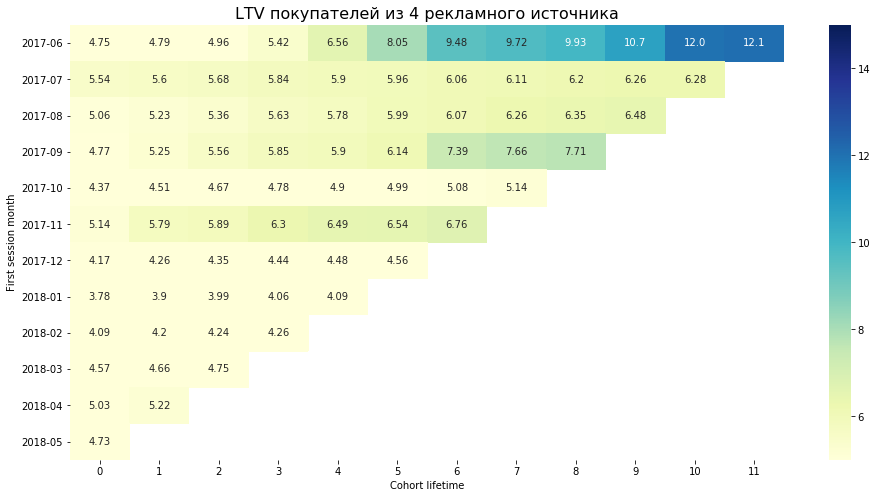

In [213]:
plt.figure(figsize=(16,8))

yticks = pd.period_range(start='2017-06-01', end='2018-05-01', freq='M')

sns.heatmap(pivot_4, annot=True, yticklabels=yticks, fmt='.3', vmin=5, vmax=15, cmap="YlGnBu")

plt.title('LTV покупателей из 4 рекламного источника', fontdict={'size':16})
plt.ylabel('First session month')
plt.xlabel('Cohort lifetime')

plt.show()

In [214]:
costs_4 = costs.loc[costs['source_id'] == 4].groupby(['source_id','month']).agg({'costs':'sum'})

In [215]:
report_4 = report_4.merge(costs_4, left_on='first_purchase_month', right_on='month')

In [216]:
report_4['cac'] = report_4['costs'] / report_4['buyers_count']

In [217]:
report_4['roi'] = report_4['ltv'] / report_4['cac']

In [218]:
report_4_roi = report_4.pivot_table(index='first_purchase_month',
                                   columns='age',
                                   values='roi',
                                   aggfunc='mean').cumsum(axis=1)

In [219]:
report_4_roi

age,0,1,2,3,4,5,6,7,8,9,10,11
first_purchase_month,,,,,,,,,,,,
2017-06-01,0.557596,0.562336,0.582414,0.636398,0.771341,0.946290,1.114240,1.141630,1.167076,1.261389,1.410496,1.420471
2017-07-01,0.812139,0.820794,0.832579,0.856043,0.864239,0.873359,0.888312,0.894941,0.907661,0.916589,0.919793,NaN
2017-08-01,0.532101,0.549820,0.563574,0.591640,0.607010,0.628944,0.637681,0.657592,0.667336,0.680281,NaN,NaN
2017-09-01,0.541641,0.596259,0.631879,0.664614,0.670267,0.697217,0.839790,0.869970,0.875832,NaN,NaN,NaN
2017-10-01,0.797284,0.823925,0.851565,0.871950,0.893710,0.910554,0.926587,0.938349,NaN,NaN,NaN,NaN
2017-11-01,1.123482,1.264895,1.286849,1.375425,1.417895,1.427450,1.475637,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.747976,0.763990,0.780472,0.795830,0.802966,0.818265,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.669090,0.690412,0.705098,0.718061,0.723333,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.792597,0.813924,0.820739,0.824323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


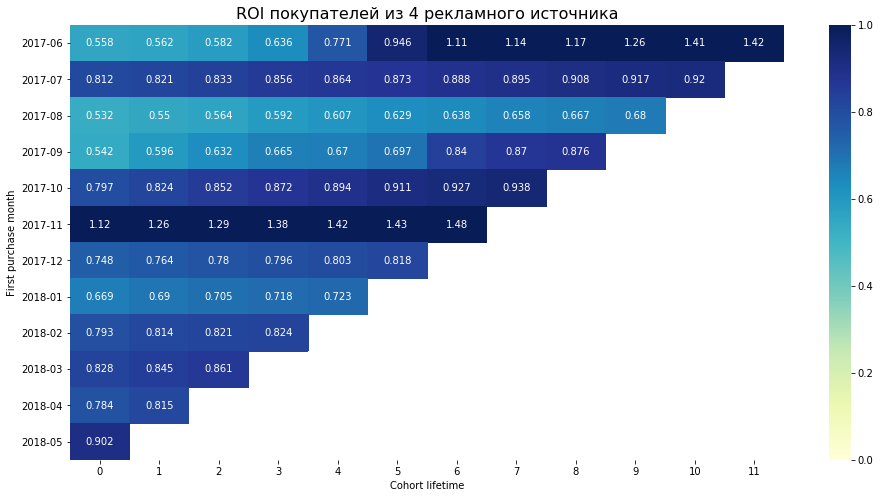

In [220]:
plt.figure(figsize=(16,8))

yticks = pd.period_range(start='2017-06-01', end='2018-05-01', freq='M')

sns.heatmap(report_4_roi, annot=True, yticklabels=yticks, fmt='.3', vmin=0, vmax=1, cmap="YlGnBu")

plt.title('ROI покупателей из 4 рекламного источника', fontdict={'size':16})
plt.ylabel('First purchase month')
plt.xlabel('Cohort lifetime')

plt.show()

In [221]:
report_4_roi.mean(axis=0)

age
0     0.757409
1     0.776915
2     0.791630
3     0.814921
4     0.843845
5     0.900297
6     0.980375
7     0.900496
8     0.904477
9     0.952753
10    1.165144
11    1.420471
dtype: float64

Инетерсные результаты у 4 канала. Он в первый месяц привлекает 75% необходимого ROI, однако до 100% доходит только на 10 месяц жизни когорты. Это говорит о том что из этого канала приходят платежеспособные люди, но они слишком долго растягивают свои платежи. Их надо поторопить:)

_Рекламный источник 5_

In [222]:
source_5 = orders_by_source.loc[orders_by_source['source_id_first_visit'] == 5]

In [223]:
first_orders_5 = source_5.groupby('uid').agg({'purchase_month':'min'}).reset_index()
first_orders_5.columns = ['uid','first_purchase_month']

In [224]:
cohort_sizes_5 = first_orders_5.groupby('first_purchase_month').agg({'uid':'nunique'}).reset_index()
cohort_sizes_5.columns = ['first_purchase_month', 'buyers_count']

In [225]:
new_orders_5 = pd.merge(source_5, first_orders_5, on='uid')

In [226]:
cohorts_5 = new_orders_5.groupby(['first_purchase_month', 'purchase_month']).agg({'revenue':'sum'}).reset_index()

In [227]:
report_5 = pd.merge(cohort_sizes_5, cohorts_5, on='first_purchase_month')

In [228]:
report_5['age'] = (report_5['purchase_month'] - report_5['first_purchase_month']) / np.timedelta64(1,'M')

In [229]:
report_5['age'] = report_5['age'].round().astype('int')

In [230]:
report_5['ltv'] = report_5['revenue'] / report_5['buyers_count']

In [231]:
pivot_5 = report_5.pivot_table(index='first_purchase_month',
                               columns='age',
                               values='ltv',
                               aggfunc='mean').cumsum(axis=1)

In [232]:
pivot_5

age,0,1,2,3,4,5,6,7,8,9,10,11
first_purchase_month,,,,,,,,,,,,
2017-06-01,4.945026,5.847969,6.297266,7.170000,7.833307,8.131042,9.036380,9.623464,10.181849,11.127422,11.283464,11.400104
2017-07-01,5.286548,5.606076,6.060827,6.214113,6.311087,6.418960,6.445390,6.555792,6.648203,6.705035,6.779835,NaN
2017-08-01,5.050139,5.802361,6.634139,7.344472,8.424167,9.018806,9.403917,9.650139,9.887917,10.122472,NaN,NaN
2017-09-01,6.196469,6.378930,6.710390,22.878319,23.651070,25.669508,25.949677,26.150272,26.172767,NaN,NaN,NaN
2017-10-01,5.091069,5.314116,5.434487,5.556582,5.669947,5.767460,5.911450,6.037143,NaN,NaN,NaN,NaN
2017-11-01,4.560390,4.747633,4.865397,4.920866,5.057922,5.097879,5.206335,NaN,NaN,NaN,NaN,NaN
2017-12-01,5.006952,5.142283,5.232231,5.287004,5.306472,5.314488,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.351754,4.870095,5.254660,5.286303,5.313902,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.321726,4.414027,4.460251,4.470118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


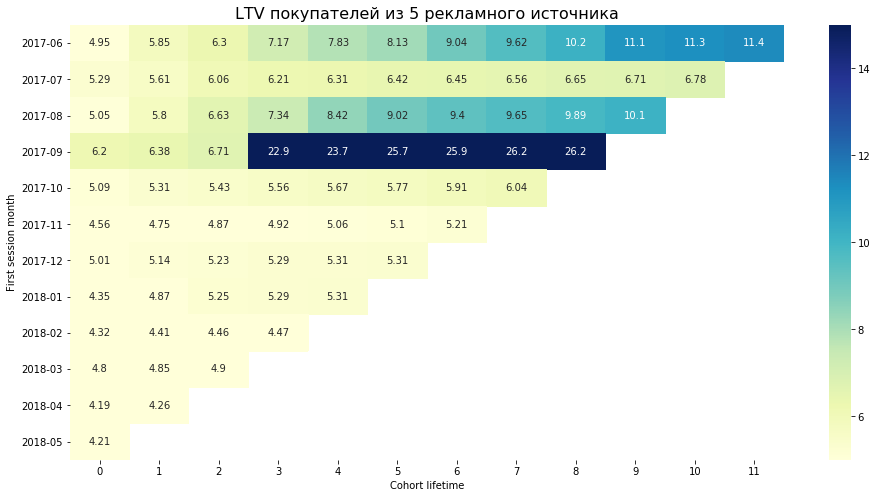

In [233]:
plt.figure(figsize=(16,8))

yticks = pd.period_range(start='2017-06-01', end='2018-05-01', freq='M')

sns.heatmap(pivot_5, annot=True, yticklabels=yticks, fmt='.3', vmin=5, vmax=15, cmap="YlGnBu")

plt.title('LTV покупателей из 5 рекламного источника', fontdict={'size':16})
plt.ylabel('First session month')
plt.xlabel('Cohort lifetime')

plt.show()

In [234]:
costs_5 = costs.loc[costs['source_id'] == 5].groupby(['source_id','month']).agg({'costs':'sum'})

In [235]:
report_5 = report_5.merge(costs_5, left_on='first_purchase_month', right_on='month')

In [236]:
report_5['cac'] = report_5['costs'] / report_5['buyers_count']

In [237]:
report_5['roi'] = report_5['ltv'] / report_5['cac']

In [238]:
report_5_roi = report_5.pivot_table(index='first_purchase_month',
                                   columns='age',
                                   values='roi',
                                   aggfunc='mean').cumsum(axis=1)

In [239]:
report_5_roi

age,0,1,2,3,4,5,6,7,8,9,10,11
first_purchase_month,,,,,,,,,,,,
2017-06-01,0.725842,0.858378,0.924327,1.052429,1.149791,1.193493,1.326380,1.412554,1.494515,1.633308,1.656212,1.673333
2017-07-01,0.745866,0.790947,0.855107,0.876734,0.890415,0.905635,0.909364,0.924940,0.937978,0.945997,0.956550,NaN
2017-08-01,0.831953,0.955873,1.092899,1.209918,1.387786,1.485746,1.549188,1.589751,1.628922,1.667562,NaN,NaN
2017-09-01,0.948191,0.976112,1.026832,3.500868,3.619115,3.927979,3.970851,4.001546,4.004988,NaN,NaN,NaN
2017-10-01,0.834182,0.870729,0.890452,0.910457,0.929032,0.945010,0.968603,0.989198,NaN,NaN,NaN,NaN
2017-11-01,0.499633,0.520148,0.533050,0.539127,0.554143,0.558520,0.570403,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.657360,0.675128,0.686937,0.694128,0.696684,0.697736,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.512827,0.573910,0.619229,0.622958,0.626210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.577786,0.590126,0.596305,0.597625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


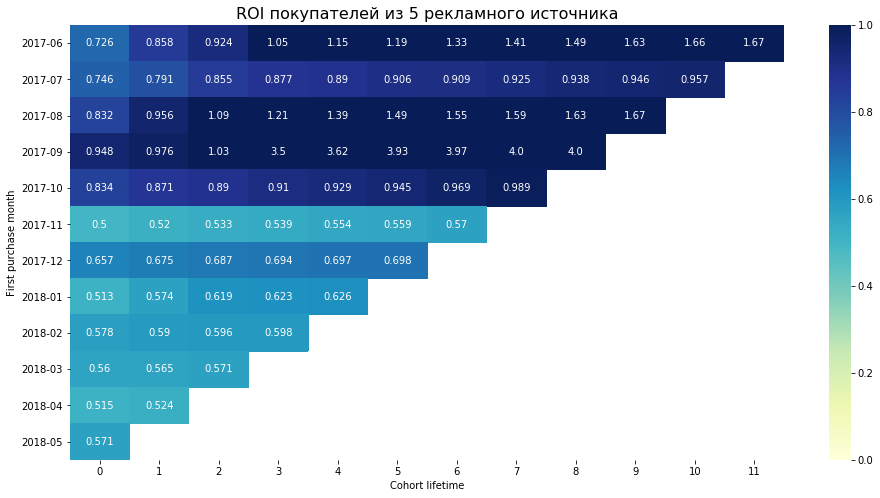

In [240]:
plt.figure(figsize=(16,8))

yticks = pd.period_range(start='2017-06-01', end='2018-05-01', freq='M')

sns.heatmap(report_5_roi, annot=True, yticklabels=yticks, fmt='.3', vmin=0, vmax=1, cmap="YlGnBu")

plt.title('ROI покупателей из 5 рекламного источника', fontdict={'size':16})
plt.ylabel('First purchase month')
plt.xlabel('Cohort lifetime')

plt.show()

In [241]:
report_5_roi.mean(axis=0)

age
0     0.664923
1     0.718179
2     0.779610
3     1.111582
4     1.231647
5     1.387731
6     1.549131
7     1.783598
8     2.016601
9     1.415622
10    1.306381
11    1.673333
dtype: float64

В среднем когорты окупаются на 3 месяц жизни. Неплохой показатель, однако он релевантен только для 1 половины года исследуемого периода. На мой взгляд на него его эффективность мог повлияться какой-то внешний фактор.

_Рекламный источник 9_

In [242]:
source_9 = orders_by_source.loc[orders_by_source['source_id_first_visit'] == 9]

In [243]:
first_orders_9 = source_9.groupby('uid').agg({'purchase_month':'min'}).reset_index()
first_orders_9.columns = ['uid','first_purchase_month']

In [244]:
cohort_sizes_9 = first_orders_9.groupby('first_purchase_month').agg({'uid':'nunique'}).reset_index()
cohort_sizes_9.columns = ['first_purchase_month', 'buyers_count']

In [245]:
new_orders_9 = pd.merge(source_9, first_orders_9, on='uid')

In [246]:
cohorts_9 = new_orders_9.groupby(['first_purchase_month', 'purchase_month']).agg({'revenue':'sum'}).reset_index()

In [247]:
report_9 = pd.merge(cohort_sizes_9, cohorts_9, on='first_purchase_month')

In [248]:
report_9['age'] = (report_9['purchase_month'] - report_9['first_purchase_month']) / np.timedelta64(1,'M')

In [249]:
report_9['age'] = report_9['age'].round().astype('int')

In [250]:
report_9['ltv'] = report_9['revenue'] / report_9['buyers_count']

In [251]:
pivot_9 = report_9.pivot_table(index='first_purchase_month',
                               columns='age',
                               values='ltv',
                               aggfunc='mean').cumsum(axis=1)

In [252]:
pivot_9

age,0,1,2,3,4,5,6,7,8,9,10
first_purchase_month,,,,,,,,,,,
2017-06-01,3.568971,3.640735,4.228676,4.835882,5.103382,5.546029,6.077941,6.201912,6.739559,6.862500,6.943382
2017-07-01,4.469038,4.627115,5.254615,5.740192,6.108077,6.169615,6.455192,6.513846,6.944423,6.967885,7.041923
2017-08-01,4.074918,4.273279,4.913934,5.145082,5.199180,5.267049,5.403279,5.693770,5.774918,5.925246,NaN
2017-09-01,4.297126,5.319770,5.949425,6.752414,7.350805,7.479195,8.094598,8.760230,9.669195,NaN,NaN
2017-10-01,5.063730,5.604048,6.042460,6.158810,6.446905,6.988651,7.006190,7.025079,NaN,NaN,NaN
2017-11-01,3.739448,3.872621,4.037241,4.323931,4.474138,4.505310,4.526345,NaN,NaN,NaN,NaN
2017-12-01,3.825868,4.139917,4.312562,4.578926,4.603140,4.749504,NaN,NaN,NaN,NaN,NaN
2018-01-01,2.834250,3.052125,3.253875,3.291125,3.314000,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.800833,4.973810,5.049762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


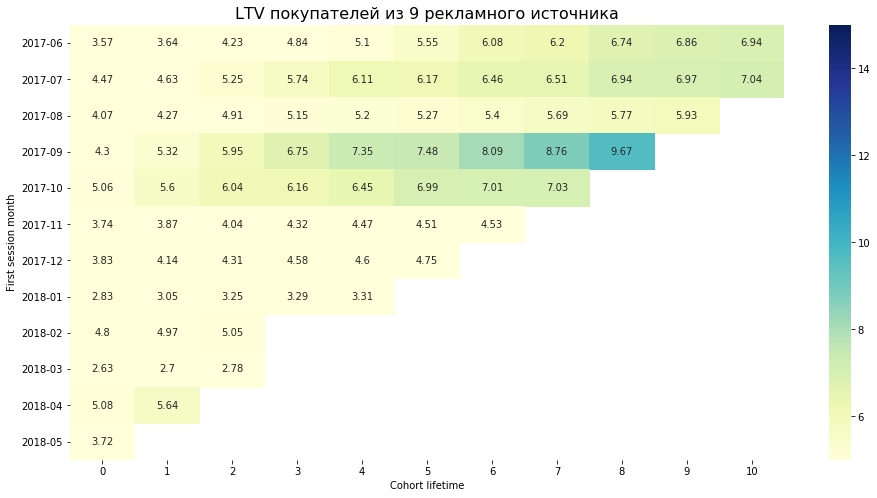

In [253]:
plt.figure(figsize=(16,8))

yticks = pd.period_range(start='2017-06-01', end='2018-05-01', freq='M')

sns.heatmap(pivot_9, annot=True, yticklabels=yticks, fmt='.3', vmin=5, vmax=15, cmap="YlGnBu")

plt.title('LTV покупателей из 9 рекламного источника', fontdict={'size':16})
plt.ylabel('First session month')
plt.xlabel('Cohort lifetime')

plt.show()

In [254]:
costs_9 = costs.loc[costs['source_id'] == 9].groupby(['source_id','month']).agg({'costs':'sum'})

In [255]:
report_9 = report_9.merge(costs_9, left_on='first_purchase_month', right_on='month')

In [256]:
report_9['cac'] = report_9['costs'] / report_9['buyers_count']

In [257]:
report_9['roi'] = report_9['ltv'] / report_9['cac']

In [258]:
report_9_roi = report_9.pivot_table(index='first_purchase_month',
                                   columns='age',
                                   values='roi',
                                   aggfunc='mean').cumsum(axis=1)

In [259]:
report_9_roi

age,0,1,2,3,4,5,6,7,8,9,10
first_purchase_month,,,,,,,,,,,
2017-06-01,0.850887,0.867997,1.008169,1.152935,1.216710,1.322242,1.449057,1.478613,1.606795,1.636105,1.655389
2017-07-01,0.768130,0.795300,0.903153,0.986613,1.049845,1.060422,1.109506,1.119587,1.193594,1.197627,1.210352
2017-08-01,0.998554,1.047162,1.204154,1.260796,1.274053,1.290684,1.324067,1.395252,1.415137,1.451974,NaN
2017-09-01,0.899500,1.113565,1.245368,1.413455,1.538713,1.565589,1.694408,1.833742,2.024012,NaN,NaN
2017-10-01,1.046963,1.158678,1.249323,1.273379,1.332945,1.444955,1.448581,1.452487,NaN,NaN,NaN
2017-11-01,0.793671,0.821936,0.856875,0.917723,0.949603,0.956219,0.960684,NaN,NaN,NaN,NaN
2017-12-01,0.703562,0.761315,0.793064,0.842047,0.846500,0.873416,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.414394,0.446250,0.475747,0.481194,0.484538,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.731224,0.757570,0.769139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


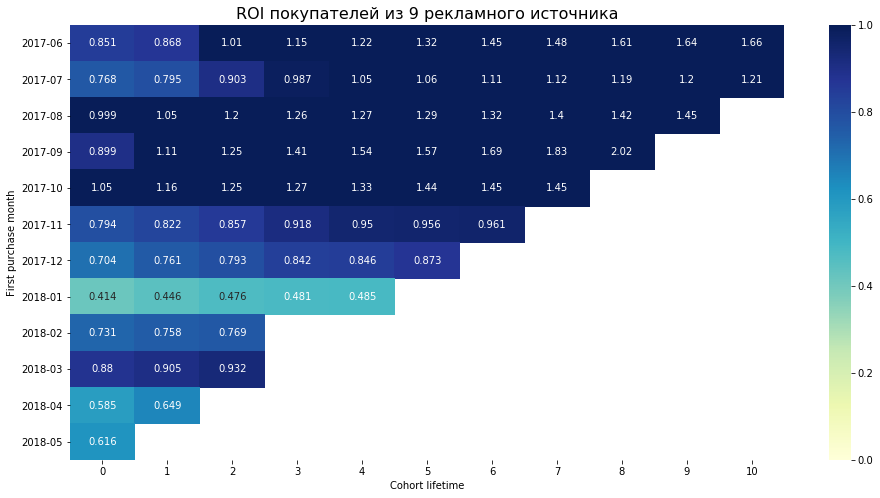

In [260]:
plt.figure(figsize=(16,8))

yticks = pd.period_range(start='2017-06-01', end='2018-05-01', freq='M')

sns.heatmap(report_9_roi, annot=True, yticklabels=yticks, fmt='.3', vmin=0, vmax=1, cmap="YlGnBu")

plt.title('ROI покупателей из 9 рекламного источника', fontdict={'size':16})
plt.ylabel('First purchase month')
plt.xlabel('Cohort lifetime')

plt.show()

In [261]:
report_9_roi.mean(axis=0)

age
0     0.774013
1     0.847641
2     0.943664
3     1.041018
4     1.086613
5     1.216218
6     1.331051
7     1.455936
8     1.559885
9     1.428569
10    1.432871
dtype: float64

Аналогичная ситуация как с 1 и 5 рекламными каналами. Первые пол года эффективен, потом спад.

_Рекламный источник 10_

In [262]:
source_10 = orders_by_source.loc[orders_by_source['source_id_first_visit'] == 10]

In [263]:
first_orders_10 = source_10.groupby('uid').agg({'purchase_month':'min'}).reset_index()
first_orders_10.columns = ['uid','first_purchase_month']

In [264]:
cohort_sizes_10 = first_orders_10.groupby('first_purchase_month').agg({'uid':'nunique'}).reset_index()
cohort_sizes_10.columns = ['first_purchase_month', 'buyers_count']

In [265]:
new_orders_10 = pd.merge(source_10, first_orders_10, on='uid')

In [266]:
cohorts_10 = new_orders_10.groupby(['first_purchase_month', 'purchase_month']).agg({'revenue':'sum'}).reset_index()

In [267]:
report_10 = pd.merge(cohort_sizes_10, cohorts_10, on='first_purchase_month')

In [268]:
report_10['age'] = (report_10['purchase_month'] - report_10['first_purchase_month']) / np.timedelta64(1,'M')

In [269]:
report_10['age'] = report_10['age'].round().astype('int')

In [270]:
report_10['ltv'] = report_10['revenue'] / report_10['buyers_count']

In [271]:
pivot_10 = report_10.pivot_table(index='first_purchase_month',
                               columns='age',
                               values='ltv',
                               aggfunc='mean').cumsum(axis=1)

In [272]:
pivot_10

age,0,1,2,3,4,5,6,7,8,9
first_purchase_month,,,,,,,,,,
2017-06-01,2.414211,2.530632,NaN,NaN,NaN,NaN,NaN,NaN,2.539579,NaN
2017-07-01,3.461373,3.492549,NaN,3.642157,NaN,NaN,NaN,NaN,3.649412,NaN
2017-08-01,4.997297,5.109459,5.439730,NaN,NaN,NaN,NaN,5.563514,NaN,5.654324
2017-09-01,2.234070,2.298721,2.381047,2.572093,2.600465,NaN,NaN,2.610349,2.635233,NaN
2017-10-01,2.618708,2.702057,2.712297,2.729234,2.767512,2.777273,2.797177,2.849187,NaN,NaN
2017-11-01,4.621797,4.674219,4.688516,4.874297,4.978984,5.028672,5.083516,NaN,NaN,NaN
2017-12-01,3.790941,3.927529,NaN,NaN,NaN,3.985059,NaN,NaN,NaN,NaN
2018-01-01,3.099022,3.114239,3.184022,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,2.473740,2.589675,2.593659,NaN,NaN,NaN,NaN,NaN,NaN,NaN


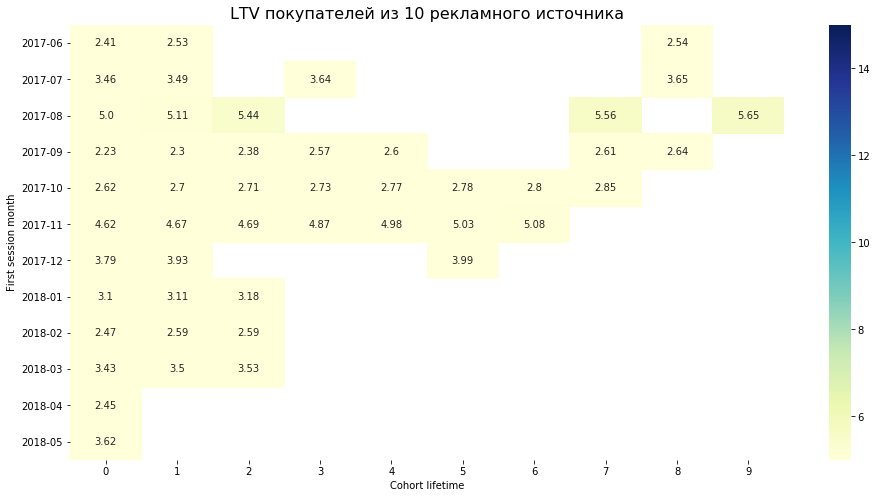

In [273]:
plt.figure(figsize=(16,8))

yticks = pd.period_range(start='2017-06-01', end='2018-05-01', freq='M')

sns.heatmap(pivot_10, annot=True, yticklabels=yticks, fmt='.3', vmin=5, vmax=15, cmap="YlGnBu")

plt.title('LTV покупателей из 10 рекламного источника', fontdict={'size':16})
plt.ylabel('First session month')
plt.xlabel('Cohort lifetime')

plt.show()

In [274]:
costs_10 = costs.loc[costs['source_id'] == 10].groupby(['source_id','month']).agg({'costs':'sum'})

In [275]:
report_10 = report_10.merge(costs_10, left_on='first_purchase_month', right_on='month')

In [276]:
report_10['cac'] = report_10['costs'] / report_10['buyers_count']

In [277]:
report_10['roi'] = report_10['ltv'] / report_10['cac']

In [278]:
report_10_roi = report_10.pivot_table(index='first_purchase_month',
                                   columns='age',
                                   values='roi',
                                   aggfunc='mean').cumsum(axis=1)

In [279]:
report_10_roi

age,0,1,2,3,4,5,6,7,8,9
first_purchase_month,,,,,,,,,,
2017-06-01,0.729903,0.765101,NaN,NaN,NaN,NaN,NaN,NaN,0.767806,NaN
2017-07-01,0.535231,0.540052,NaN,0.563186,NaN,NaN,NaN,NaN,0.564308,NaN
2017-08-01,0.795029,0.812874,0.865417,NaN,NaN,NaN,NaN,0.885110,NaN,0.899557
2017-09-01,0.417066,0.429136,0.444505,0.480170,0.485467,NaN,NaN,0.487312,0.491957,NaN
2017-10-01,0.872569,0.900341,0.903753,0.909397,0.922151,0.925403,0.932036,0.949365,NaN,NaN
2017-11-01,0.746618,0.755086,0.757396,0.787407,0.804319,0.812345,0.821205,NaN,NaN,NaN
2017-12-01,0.498916,0.516892,NaN,NaN,NaN,0.524464,NaN,NaN,NaN,NaN
2018-01-01,0.464084,0.466363,0.476813,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.632736,0.662390,0.663409,NaN,NaN,NaN,NaN,NaN,NaN,NaN


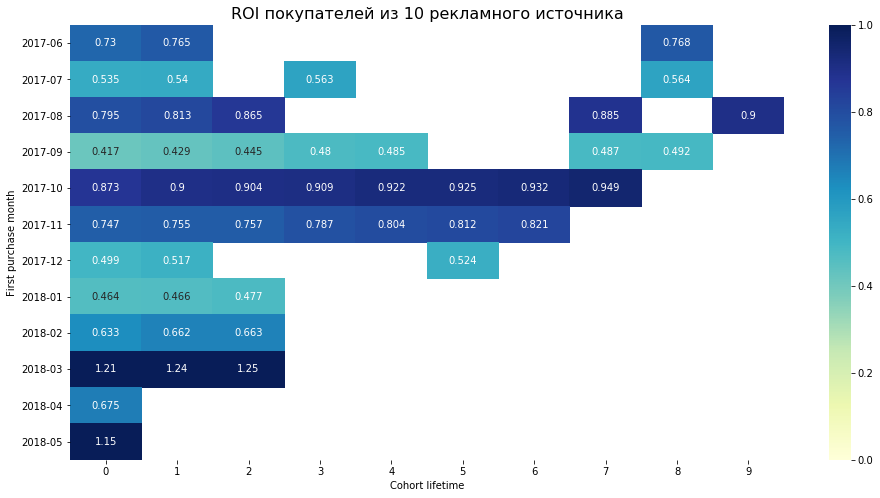

In [280]:
plt.figure(figsize=(16,8))

yticks = pd.period_range(start='2017-06-01', end='2018-05-01', freq='M')

sns.heatmap(report_10_roi, annot=True, yticklabels=yticks, fmt='.3', vmin=0, vmax=1, cmap="YlGnBu")

plt.title('ROI покупателей из 10 рекламного источника', fontdict={'size':16})
plt.ylabel('First purchase month')
plt.xlabel('Cohort lifetime')

plt.show()

In [281]:
report_10_roi.mean(axis=0)

age
0    0.727377
1    0.708520
2    0.765743
3    0.685040
4    0.737312
5    0.754071
6    0.876620
7    0.773929
8    0.608024
9    0.899557
dtype: float64

На тепловой карте видно что канал используется с самого начала рассматриваемого периода, но приносит крайне мало пользователей. Еще меньше приходит из него покупателей. Средние показатели все ниже 1. Однако 2 когорты из числа самых последних окупились в первый месяц. Может маркетологи в этом канале, наоборот, только спустя год нащупали своих клиентов? в перспективе он может показать результат лучше.

#### _Как метрики отличаются по устройствам?_ 

In [282]:
desktop_dau_mean = (visits
                    .query('device == "desktop"')
                    .groupby(['session_year','session_date'])
                    .agg({'uid':'nunique'}).mean()
                   )

In [283]:
desktop_wau_mean = (visits
                    .query('device == "desktop"')
                    .groupby(['session_year','session_week'])
                    .agg({'uid':'nunique'}).mean()
                   )

In [284]:
desktop_mau_mean = (visits
                    .query('device == "desktop"')
                    .groupby(['session_year','session_month'])
                    .agg({'uid':'nunique'}).mean()
                   )

In [285]:
touch_dau_mean = (visits
                    .query('device == "touch"')
                    .groupby(['session_year','session_date'])
                    .agg({'uid':'nunique'}).mean()
                   )

In [286]:
touch_wau_mean = (visits
                    .query('device == "touch"')
                    .groupby(['session_year','session_week'])
                    .agg({'uid':'nunique'}).mean()
                   )

In [287]:
touch_mau_mean = (visits
                    .query('device == "touch"')
                    .groupby(['session_year','session_month'])
                    .agg({'uid':'nunique'}).mean()
                   )

In [288]:
int(desktop_dau_mean)

659

In [289]:
int(desktop_wau_mean)

4129

In [290]:
int(desktop_mau_mean)

16724

In [291]:
int(touch_dau_mean)

252

In [292]:
int(touch_wau_mean)

1634

In [293]:
int(touch_mau_mean)

6825

In [294]:
sessions_by_device = visits.groupby(['session_date','device']).agg({'uid':['count','nunique']})

In [295]:
sessions_by_device.columns = ['n_sessions','n_unique']

In [296]:
sessions_by_device['session_per_user'] = sessions_by_device['n_sessions'] / sessions_by_device['n_unique']

In [297]:
sessions_by_device.query('device == "desktop"')['session_per_user'].mean()

1.0889553115247612

In [298]:
sessions_by_device.query('device == "touch"')['session_per_user'].mean()

1.0510715741665035

_Retention rate для пользователей устройств desktop_

In [299]:
desktop = visits.loc[visits['device'] == 'desktop'].copy()

In [300]:
cohorts_desktop_rr = desktop.groupby(['first_session_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

In [301]:
initial_desktop_users_count = (cohorts_desktop_rr[cohorts_desktop_rr['cohort_lifetime'] == 0]
                               [['first_session_month','uid']]
                              )

In [302]:
initial_desktop_users_count = initial_desktop_users_count.rename(columns={'uid':'cohort_users'})

In [303]:
cohorts_desktop_rr = cohorts_desktop_rr.merge(initial_desktop_users_count, on='first_session_month')

In [304]:
cohorts_desktop_rr['retention'] = cohorts_desktop_rr['uid'] / cohorts_desktop_rr['cohort_users']

In [305]:
rr_desktop_pivot = cohorts_desktop_rr.pivot_table(index='first_session_month',
                                          columns='cohort_lifetime',
                                          values='retention',
                                          aggfunc='sum')

In [306]:
rr_desktop_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_session_month,,,,,,,,,,,,
2017-06-01,1.0,0.085340,0.060752,0.068743,0.075914,0.081856,0.067206,0.064235,0.058805,0.056552,0.045180,0.048253
2017-07-01,1.0,0.060997,0.055842,0.060997,0.064648,0.051869,0.050043,0.049721,0.041989,0.031035,0.028458,NaN
2017-08-01,1.0,0.080940,0.066040,0.067651,0.054497,0.046846,0.037450,0.040537,0.031409,0.029262,NaN,NaN
2017-09-01,1.0,0.088263,0.074691,0.055911,0.041400,0.042254,0.038412,0.025779,0.023816,NaN,NaN,NaN
2017-10-01,1.0,0.082922,0.055011,0.040106,0.036909,0.035012,0.022926,0.022384,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.080431,0.044811,0.040042,0.033832,0.024293,0.022405,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.052654,0.038353,0.030607,0.020098,0.020098,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.062117,0.040357,0.026124,0.021317,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.060118,0.026819,0.020018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


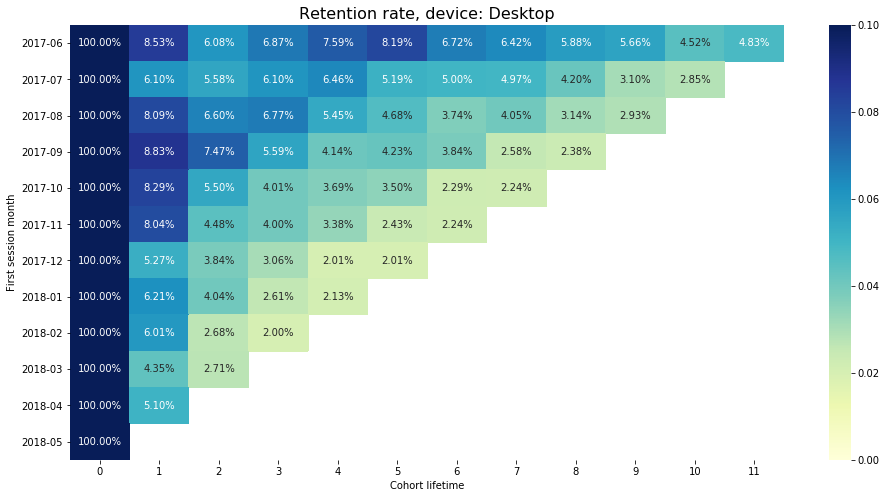

In [307]:
plt.figure(figsize=(16,8))

yticks = pd.period_range(start='2017-06-01', end='2018-05-01', freq='M')

sns.heatmap(rr_desktop_pivot, annot=True, yticklabels=yticks, fmt='.2%', vmin=0, vmax=0.1, cmap="YlGnBu")

plt.title('Retention rate, device: Desktop', fontdict={'size':16})
plt.ylabel('First session month')
plt.xlabel('Cohort lifetime')

plt.show()

_Retention rate для пользователей устройств touch_

In [308]:
touch = visits.loc[visits['device'] == 'touch'].copy()

In [309]:
cohorts_touch_rr = touch.groupby(['first_session_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

In [310]:
initial_touch_users_count = (cohorts_touch_rr[cohorts_touch_rr['cohort_lifetime'] == 0]
                            [['first_session_month','uid']]
                              )

In [311]:
initial_touch_users_count = initial_touch_users_count.rename(columns={'uid':'cohort_users'})

In [312]:
cohorts_touch_rr = cohorts_touch_rr.merge(initial_touch_users_count, on='first_session_month')

In [313]:
cohorts_touch_rr['retention'] = cohorts_touch_rr['uid'] / cohorts_touch_rr['cohort_users']

In [314]:
rr_touch_pivot = cohorts_touch_rr.pivot_table(index='first_session_month',
                                              columns='cohort_lifetime',
                                              values='retention',
                                              aggfunc='sum')

In [315]:
rr_touch_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_session_month,,,,,,,,,,,,
2017-06-01,1.0,0.065937,0.039672,0.047332,0.058550,0.055267,0.054993,0.045964,0.042681,0.042955,0.034473,0.042681
2017-07-01,1.0,0.047966,0.043697,0.048970,0.047966,0.044450,0.037670,0.037921,0.034907,0.024611,0.027373,NaN
2017-08-01,1.0,0.071173,0.057582,0.055436,0.040773,0.040057,0.035408,0.039700,0.019671,0.019671,NaN,NaN
2017-09-01,1.0,0.084941,0.061562,0.044224,0.037210,0.031560,0.032340,0.020456,0.021625,NaN,NaN,NaN
2017-10-01,1.0,0.073376,0.049045,0.037325,0.030701,0.027643,0.018344,0.016051,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.077747,0.044962,0.036398,0.035461,0.021410,0.020206,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.066620,0.038451,0.033380,0.020141,0.016901,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.058421,0.038757,0.022514,0.018524,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.052447,0.022561,0.020803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


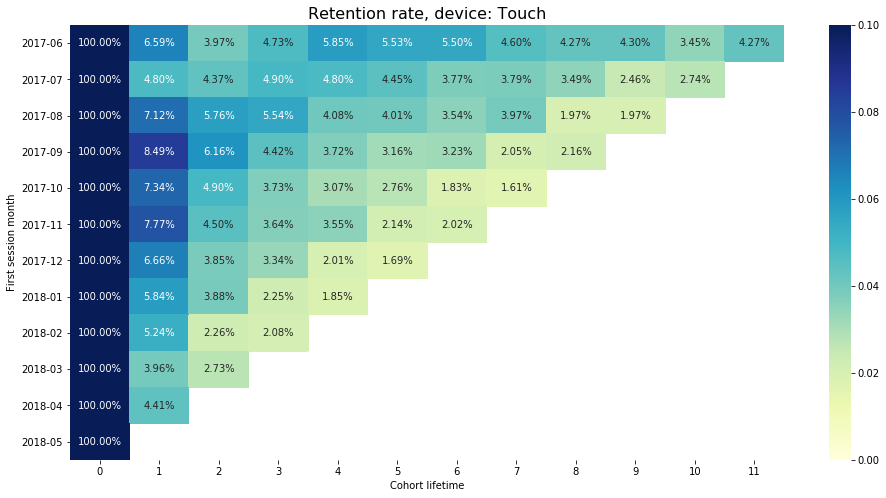

In [316]:
plt.figure(figsize=(16,8))

yticks = pd.period_range(start='2017-06-01', end='2018-05-01', freq='M')

sns.heatmap(rr_touch_pivot, annot=True, yticklabels=yticks, fmt='.2%', vmin=0, vmax=0.1, cmap="YlGnBu")

plt.title('Retention rate, device: Touch', fontdict={'size':16})
plt.ylabel('First session month')
plt.xlabel('Cohort lifetime')

plt.show()

## Вывод и рекомендации <a id="conclusion"></a>

Детально проанализировав показатель ROI для каждого рекламного источника, я могу сделать следующие выводы:
- 1,5,9 рекламные источники я могу отнести в одну группу. Они похожи друг на друга тем что в них некоторые (от 3 до 6) старые (пришедшие в первые 6 месяцев) когорты окупаются в первые 4 месяца. Однако новые когорты не показывают такой темп окупаемости и большинство из них не окупились за рассматриваемый период. Этот факт наталкивает на мысль что либо поменялся характер рекламной кампании и из этих источников стали приходить другие пользователи и, соответственно, тратить меньше, либо произошли изменения на самом сайте, которые привели к уменьшению покупательской активности новых пользователей. Стоимость привлечения 1 покупателя у этих рекламных каналов сопоставима друг с другом: 7.1,7.4,5.0 соответственно. Поэтому можно сделать вывод что из этих каналов приходят "правильные" пользователи/покупатели, которые окупаются с течением времени. Эти каналы точно стоит использовать и дальше, но необходимо детально изучать случались ли какие-либо изменения;
- 2 рекламный источник очень неоднороден по времени окупаемости покупателей, однако половина всех когорт окупилась. Возможно это связано с характером рекламных кампаний в источнике. Например акции приуроченные к определенным датам и событиям могут оказывать такой эффект на график. Сам по себе рекламный источник 2ой по стоимости привлечения покупателя, на него приходится около 10% всех покупателей. Я бы рекомендовал его оставить, половина пришедших из него пользователей окупилась, но вероятно стоит уделить ему больше внимания и детально проработать чтобы повысить эффективность;
- 3 рекламный источник, из него пришло больше всего покупателей. При этом по стоимости привлечения он на 1 месте, с результатом 13.5. Ни одна когорта покупателей пришедших из этого источника за целый год не окупилась. Из этого источника приходят нецелевые пользователи/покупатели. Вероятно очень низкий ROI именно этого рекламного источника утягивает общий покататель ROI вниз, а тот в свою очередь свидетельствует о неэффективности рекламных расходов. 3 рекламный источник - первый от которого необходимо отказаться;
- 4 рекламный источник показывает слабые, но многообещающие результаты. Из него приходит очень много покупателей, но окупаются они очень долго. График ROI 4 источника показывает что из него приходят платежеспособная аудитория, но почти всем когортам немного не хватает для преодоления отметки окупаемости. С этим рекламным источником необходимо продолжать работать дальше, но так же детально изучить поведение покупателей пришедших из него и найти способы добрать необходимые платежи для их окупаемости;
- 10 рекламный источник показывает мало результатов для адекватной оценки его эффективности. 2 старые когорты близки к окупаемости. Но более интересен тот факт что 2 новые когорты окупились в первый месяц своей жизни, что говорит о том что новые пользователи приходящие из этого источника осуществляют необходимые сервису платежи. Новые когорты окупились только из 1 и 10 рекламного источника, при том что общий тренд возврата новых пользователей снижается, 10 источник так же стоит изучить детальнее чтобы точно описать потрет пользователя приходящего из этого источника.

В целом количество пользователей утройств desktop и touch находится в пропорции 70 / 30. Количество сессий на пользователя в день сопоставимо: 1.08 и 1.05. Однако стоит отметить что Retention rate у пользователей устроств touch снижается немного быстрее чем у пользователей desktop.